# Introduction to Stochastic Variational Inference (SVI) with NumPyro

In this notebook we provide a brief introduction to Stochastic Variational Inference (SVI) with [NumPyro](https://pyro.ai/numpyro). We provide the key mathematical concepts, but we focus on the code implementation. This introductory notebook is meant for practitioners. We do this by working two examples: a very simple parameter recovery model and a Bayesian Neural Network.

## Overview

**Stochastic Variational Inference (SVI)** is a scalable approximate inference method that transforms the problem of posterior inference into an optimization problem. Instead of sampling from the posterior distribution (like MCMC), SVI finds the best approximation to the posterior within a family of simpler distributions.

### Why Use SVI?

1. **Scalability**: SVI can handle large datasets through mini-batching and stochastic optimization.
2. **Speed**: Generally faster than MCMC for large models and datasets.

### Key Concepts

The following are the key concepts of SVI that you should understand after reading this notebook:

- **Variational Family**: A family of simple distributions (e.g., Normal) parameterized by variational parameters
- **ELBO (Evidence Lower BOund)**: The objective function we maximize, which lower-bounds the log marginal likelihood
- **Guide Function**: Defines the variational approximation to the posterior

### The Mathematical Foundation

As we will explain below, the whole idea of SVI to fit Bayesian models is to convert the sampling problem into an optimization problem.
How? The idea is to impose a parametric functional form (approximation) to the posterior distribution so that we can learn the parameters by maximizing 
a quantity that somehow captures the posterior distribution and that we can compute, namely the Evidence Lower BOund (ELBO). To understand this, let's first establish our notation:

**Notation:**

- $\theta$: Model parameters (neural network weights and biases)
- $\phi$: Variational parameters (parameters of our approximate posterior)
- $x$: Observed input data
- $y$: Observed output data
- $D = \{(x_i, y_i)\}_{i=1}^N$: Our complete dataset
- $p(\theta|D)$: True posterior distribution (what we want but can't compute easily)
- $q_\phi(\theta)$: Variational approximation to the posterior (what we'll optimize)

The ELBO can be written as:

$$\text{ELBO}(\phi) = \mathbb{E}_{q_\phi(\theta)}[\log p(y|x, \theta) + \log p(\theta) - \log q_\phi(\theta)]$$

This decomposes into three intuitive terms:

- $\mathbb{E}_{q_\phi(\theta)}[\log p(y|x, \theta)]$: Expected log-likelihood (how well we explain the data)
- $\mathbb{E}_{q_\phi(\theta)}[\log p(\theta)]$: Expected log-prior (staying close to prior beliefs)
- $\mathbb{E}_{q_\phi(\theta)}[\log q_\phi(\theta)]$: Entropy of variational distribution (encouraging exploration)

The ELBO is a lower bound on the log marginal likelihood, which is the quantity we want to maximize.

Here, it is enought to understand the main idea without going into the mathematical nuances. We will give some additional details, but the core objective is to work out a concrete end-to-end example. For more on the mathematical foundations of SVI, please see [Blei et al. (2017): Variational Inference Review](https://arxiv.org/abs/1601.00670).

## Example 1: Simple Gamma Distribution Approximation

We start with a simple example to illustrate the main ideas of SVI. We will approximate a Gamma distribution and try to do a parameter recovery exercise.
We will go fast in this example as we simply want to illustrate the key steps of the SVI workflow. In the next example, we will delve deeper into the details.

## Example 2: Bayesian Neural Network Classification

As the main example of this notebook, we'll implement a Bayesian Neural Network (BNN) for binary classification using SVI. We'll:

1. Generate synthetic data (two moons dataset)
2. Define a Bayesian neural network model
3. Create a variational guide (approximate posterior)
4. Train using SVI optimization
5. Evaluate the model and quantify uncertainty


**Practical Resources:** Here are two great resources for practitioners:

- [Pyro](https://pyro.ai/) documentation is a great resource for SVI. See for example, the [introductory tutorial](https://pyro.ai/examples/intro_long.html).
- For an introduction to SVI in PyMC, please see the amazing tutorial: [A Beginner's Guide to Variational Inference | PyData Virginia 2025](https://www.youtube.com/watch?v=XECLmgnS6Ng) by [Chris Fonnesbeck](https://github.com/fonnesbeck).

## Prepare Notebook

In [1]:
from itertools import pairwise

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
import seaborn as sns
import tqdm
import xarray as xr
from flax import nnx
from jax import random
from jaxtyping import Array, Float, Int
from numpyro.contrib.module import random_nnx_module
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.infer.svi import SVIRunResult
from sklearn.datasets import make_moons
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split

seed = 42
rng_key = random.PRNGKey(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%load_ext jaxtyping
%jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Toy Example: Gamma Distribution Approximation

In this initial example, we will approximate a Gamma distribution using stochastic variational inference. We will use specify the model and guide (variational approximation) to approximate the posterior distribution of the Gamma distribution parameters as a Normal distribution. The main objective of this example is to quickly go through the SVI workflow.



We generate synthetic data from a Gamma distribution with a concentration ($\alpha$) of 2.0 and a rate ($\beta$) of 1.0.

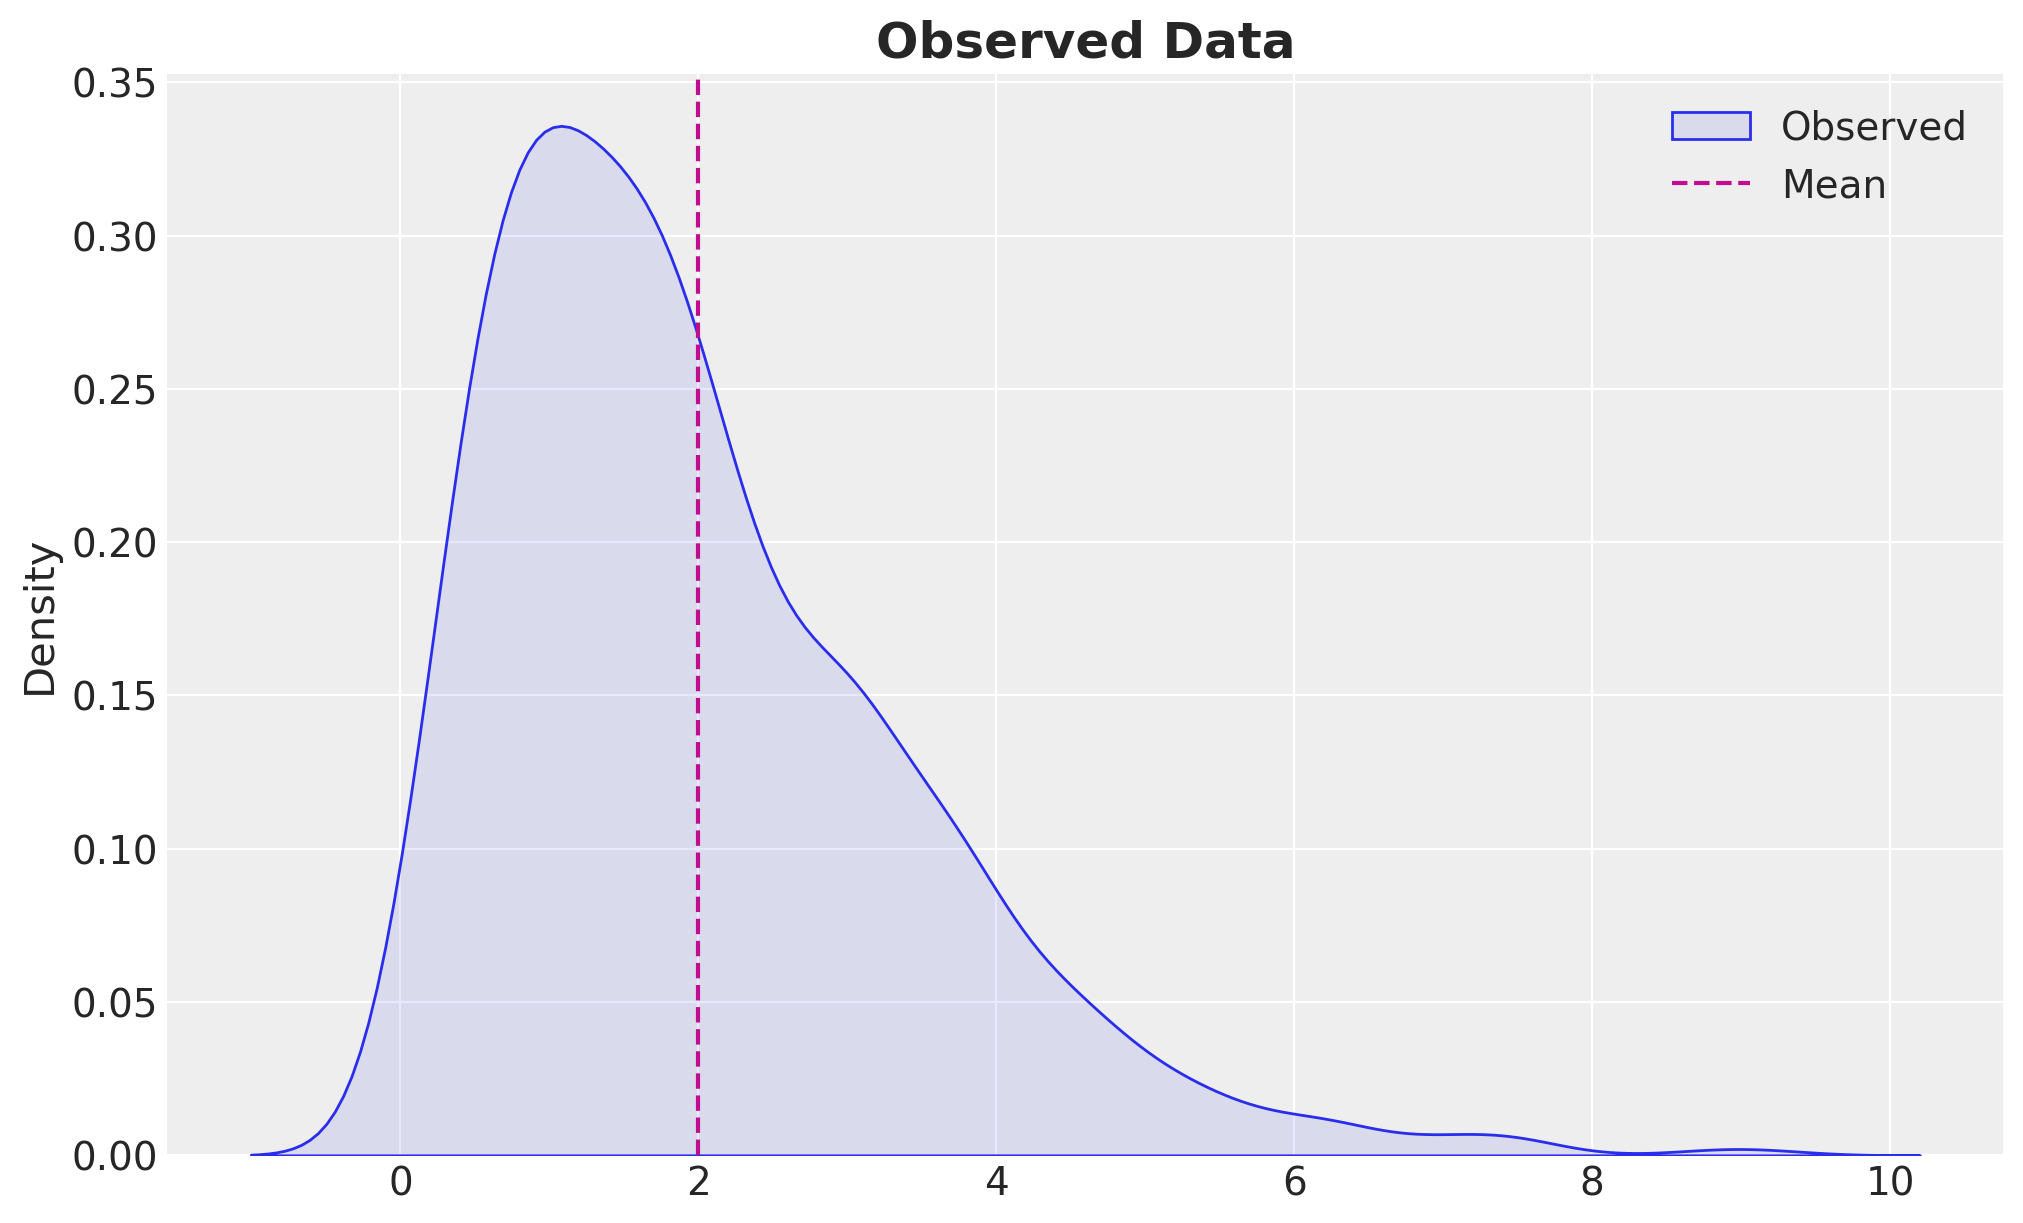

In [2]:
# Generate toy data samples from a Gamma distribution
rng_key, rng_subkey = random.split(rng_key)
concentration = 2.0
n_obs = 1_000
z = random.gamma(rng_subkey, a=concentration, shape=(n_obs,))

fig, ax = plt.subplots()
sns.kdeplot(z, fill=True, alpha=0.1, label="Observed", ax=ax)
ax.axvline(concentration / 1.0, color="C3", linestyle="--", label="Mean")
ax.legend()
ax.set_title("Observed Data", fontsize=18, fontweight="bold");

Next, we define the model we use to model the data. We are interested in learning the distribution of the concentration parameter.

In [3]:
# Define the model
def model(z: jax.Array | None = None) -> None:
    # Set the prior for the concentration parameter (it has to be positive!)
    concentration = numpyro.sample("concentration", dist.HalfNormal(scale=1))
    rate = 1.0
    # Generate the data from the Gamma distribution
    numpyro.sample("z", dist.Gamma(concentration=concentration, rate=rate), obs=z)

We continue, by defining the variational approximation, i.e. the guide function. For this example, we will use a Normal distribution to approximate the posterior distribution of the concentration parameter. For this, we need to learn the location and scale parameters of the normal distribution.

In [4]:
# Define the guide
# It approximates the posterior distribution of the model parameters
# with a normal distribution
def guide(z: jax.Array | None = None) -> None:
    # Define the location and scale parameters of the normal distribution
    concentration_loc = numpyro.param("concentration_loc", init_value=0.5)
    # Define the scale parameter of the normal distribution
    # It has to be positive!
    concentration_scale = numpyro.param(
        "concentration_scale",
        init_value=0.1,
        constraint=dist.constraints.positive,
    )
    # We need to make sure the guide has the same sample statements as the model
    # (for the distributions we want to infer)
    numpyro.sample(
        "concentration", dist.Normal(loc=concentration_loc, scale=concentration_scale)
    )

**Remark [AutoGuides]:** In many applications, using auto-guides is a good idea to start with. For instance, this example can be also solved using an [`AutoNormal`](https://num.pyro.ai/en/latest/autoguide.html#numpyro.infer.autoguide.AutoNormal) guide.

We are ready to define the SVI algorithm components and run the algorithm in NumPyro. Namely, we need to define the loss function, the optimizer, and the SVI object.

In [5]:
# Define the loss function (ELBO)
loss = Trace_ELBO(num_particles=10)
# Define the optimizer
optimizer = optax.adam(learning_rate=0.005)
# Define the SVI algorithm
svi = SVI(model=model, guide=guide, optim=optimizer, loss=loss)

We now run the optimization routine and plot the ELBO loss as a function of the number of steps. Remember this is the loss function that we are trying to minimize.

100%|██████████| 1000/1000 [00:00<00:00, 2672.24it/s, init loss: 2869.5586, avg. loss [951-1000]: 1590.9209]


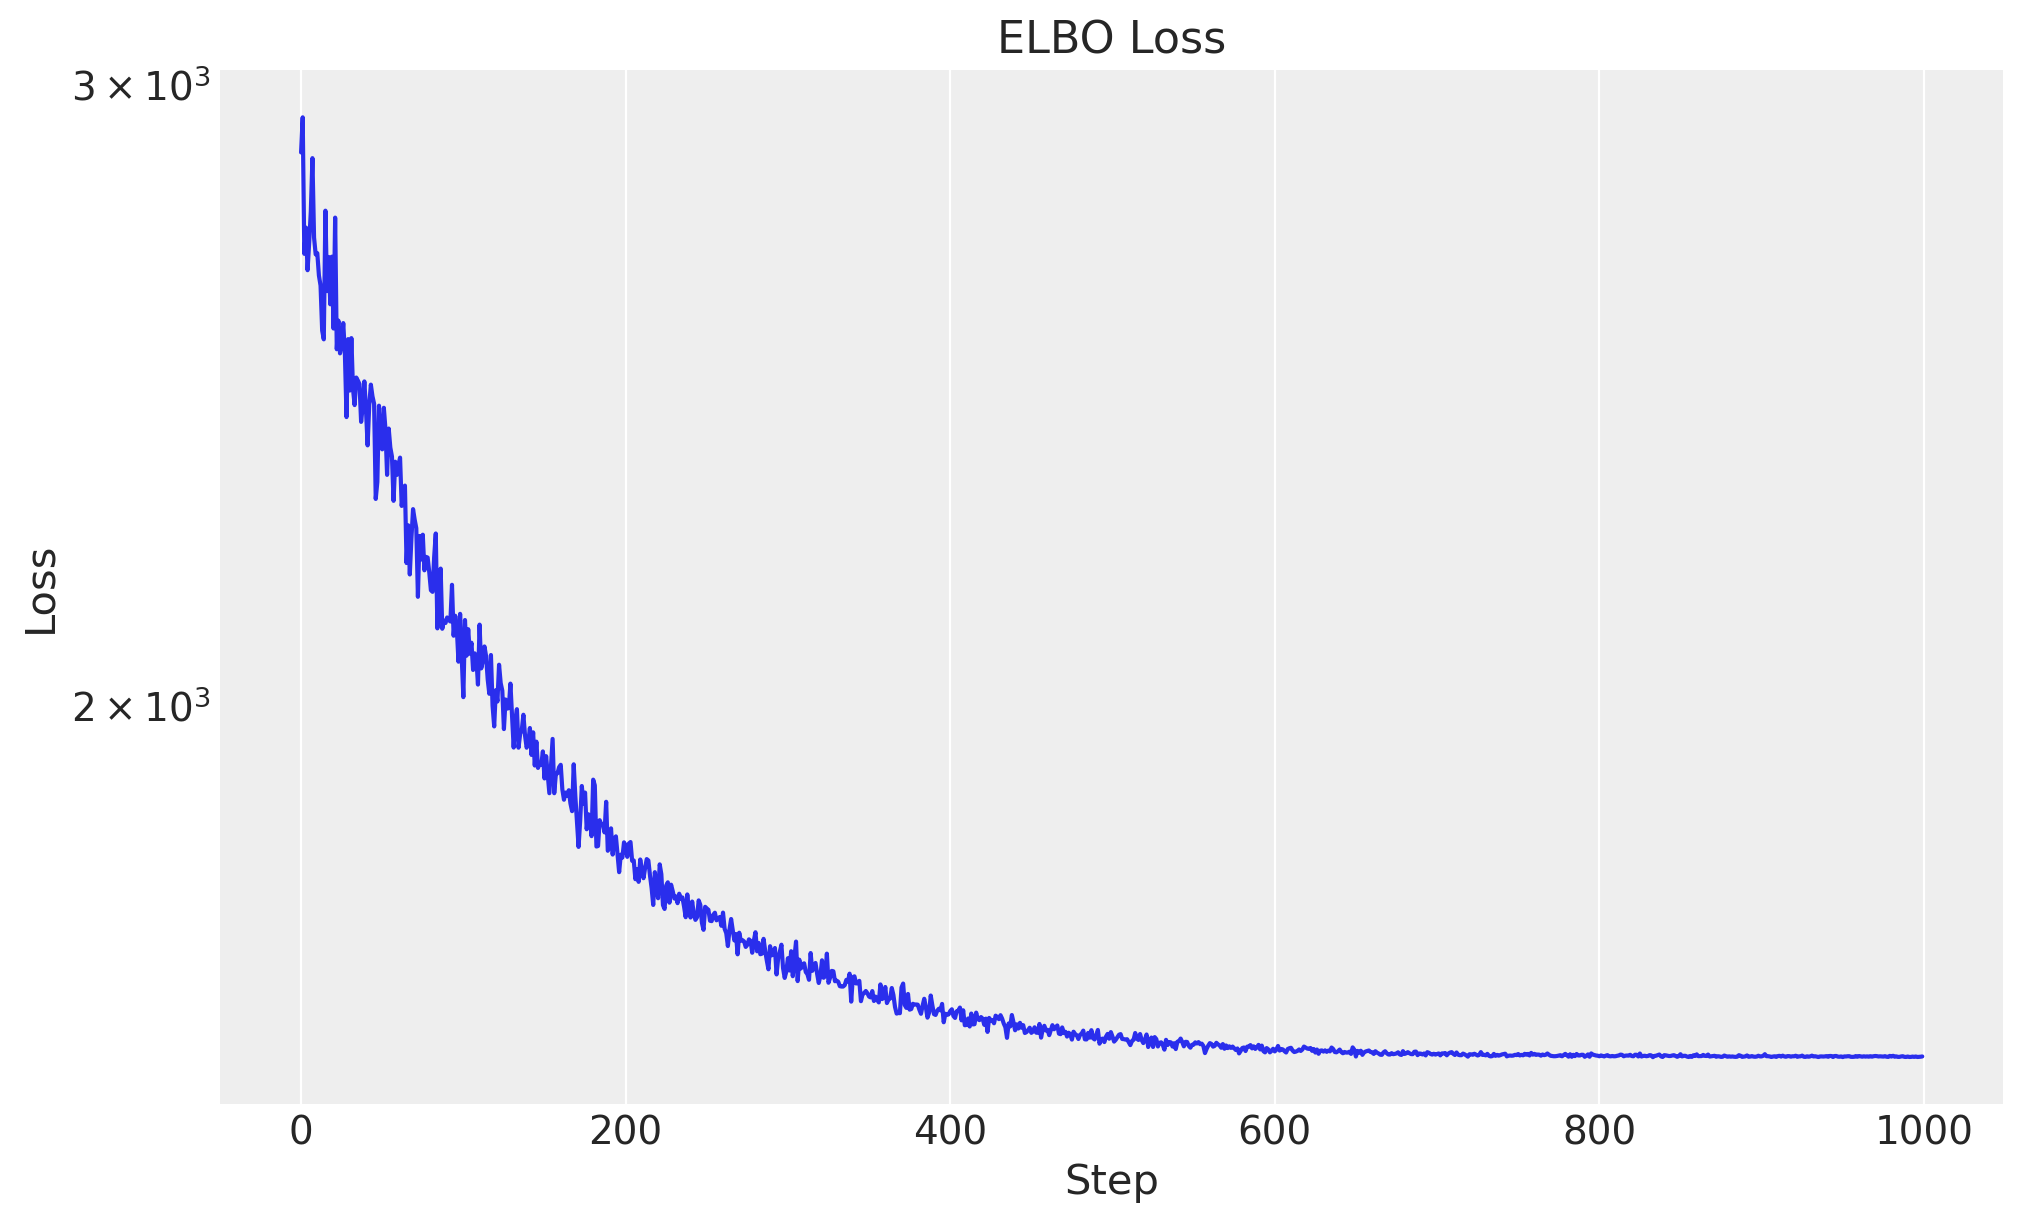

In [6]:
# Run the SVI algorithm
rng_key, rng_subkey = random.split(rng_key)
svi_result = svi.run(rng_subkey, num_steps=1_000, z=z, progress_bar=True)

fig, ax = plt.subplots()
ax.plot(svi_result.losses)
ax.set(yscale="log")
ax.set(title="ELBO Loss", xlabel="Step", ylabel="Loss");

As expected, the loss decreases as the number of steps increases. Also, it seems we reached a stable value for the loss.

How can we now recover the concentration parameter? Let's look at the results.

In [7]:
svi_result.params

{'concentration_loc': Array(1.9850353, dtype=float32),
 'concentration_scale': Array(0.0569637, dtype=float32)}

We can use these values to sample for a normal distributon to get the posterior samples of the concentration parameter.

In [8]:
rng_key, rng_subkey = random.split(rng_key)

concentration_posterior_samples = (
    svi_result.params["concentration_loc"]
    + random.normal(rng_subkey, shape=(4_000,))
    * svi_result.params["concentration_scale"]
)

We can now generate posterior predictive samples by using these concentration parameters to sample from a Gamma distribution.

In [9]:
rng_key, rng_subkey = random.split(rng_key)
posterior_samples = random.gamma(rng_subkey, a=concentration_posterior_samples)

Let's visualize the results:

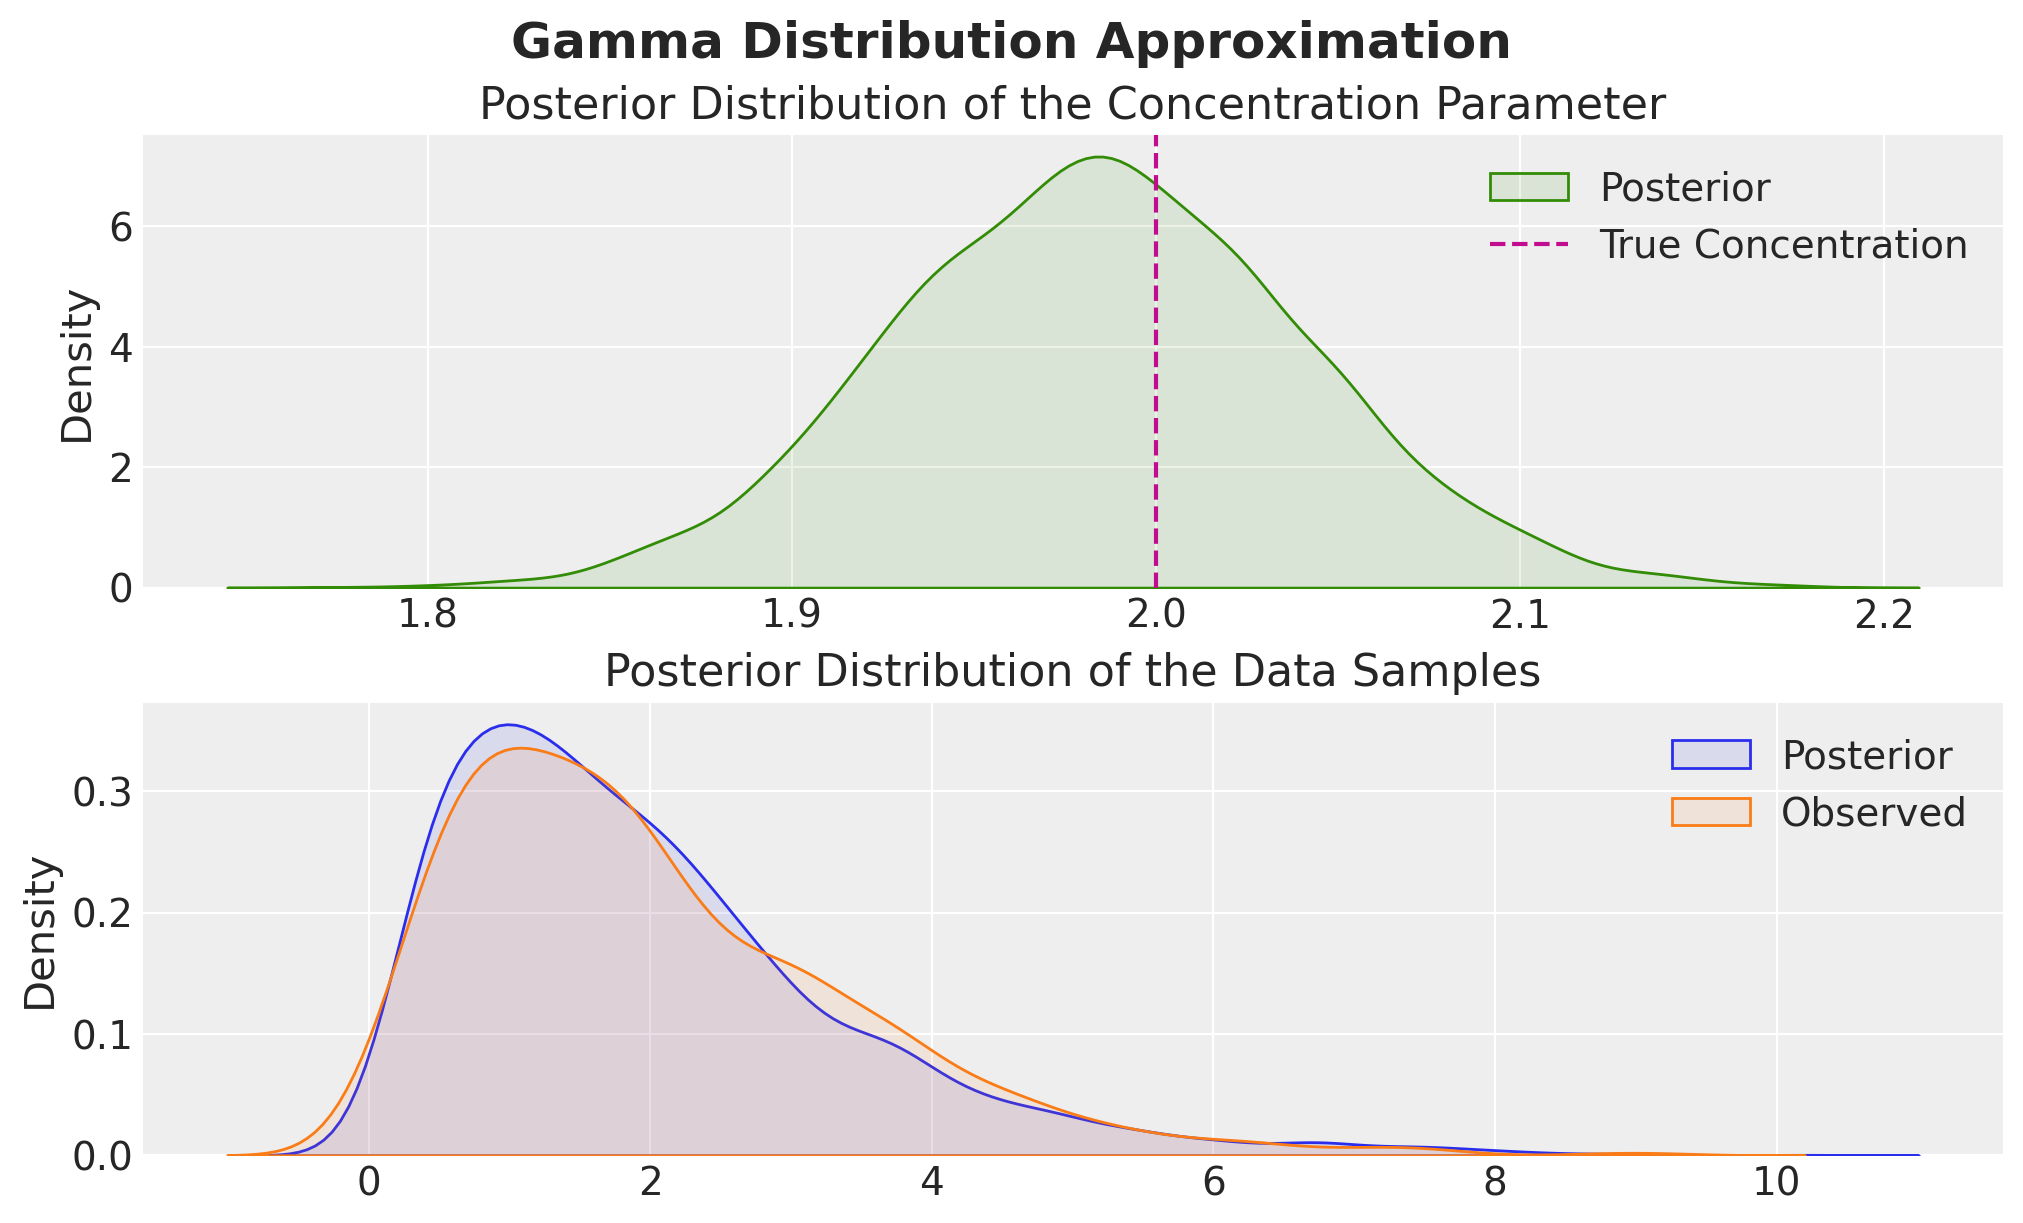

In [10]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    sharex=False,
    sharey=False,
    figsize=(10, 6),
    layout="constrained",
)

sns.kdeplot(
    concentration_posterior_samples,
    fill=True,
    alpha=0.1,
    color="C2",
    label="Posterior",
    ax=ax[0],
)
ax[0].axvline(concentration, color="C3", linestyle="--", label="True Concentration")
ax[0].legend()
ax[0].set(title="Posterior Distribution of the Concentration Parameter")

sns.kdeplot(posterior_samples, fill=True, alpha=0.1, label="Posterior", ax=ax[1])
sns.kdeplot(z, fill=True, alpha=0.1, label="Observed", ax=ax[1])
ax[1].legend()
ax[1].set(title="Posterior Distribution of the Data Samples")
fig.suptitle("Gamma Distribution Approximation", fontsize=18, fontweight="bold");

The results are exactly as expected!

One could imagine that for more complex models doing this forward pass of the posterior samples can become very cumbersome. Fortunately, NumPyro provides a convenient way to do this. Let's see how we can do this.

In [11]:
# This time we use an AutoNormal guide
guide = AutoNormal(model)

# Define the loss function (ELBO)
loss = Trace_ELBO(num_particles=10)
# Define the optimizer
optimizer = optax.adam(learning_rate=0.005)
# Define the SVI algorithm
svi = SVI(model=model, guide=guide, optim=optimizer, loss=loss)

# Run the SVI algorithm
rng_key, rng_subkey = random.split(rng_key)
svi_result = svi.run(rng_subkey, num_steps=1_000, z=z, progress_bar=False)

# Generate posterior samples from the model (forward pass)
posterior = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=1_000,
    return_sites=["concentration", "z"],
)
rng_key, rng_subkey = random.split(rng_key)
posterior_samples = posterior(rng_key, z=z)

# Store the posterior samples in an ArviZ InferenceData object
idata = az.from_dict(
    posterior={
        k: np.expand_dims(a=np.asarray(v), axis=0) for k, v in posterior_samples.items()
    },
    coords={"obs_idx": range(len(z))},
    dims={"z": ["obs_idx"]},
)

Let's visualize the results from the convenient inference object.

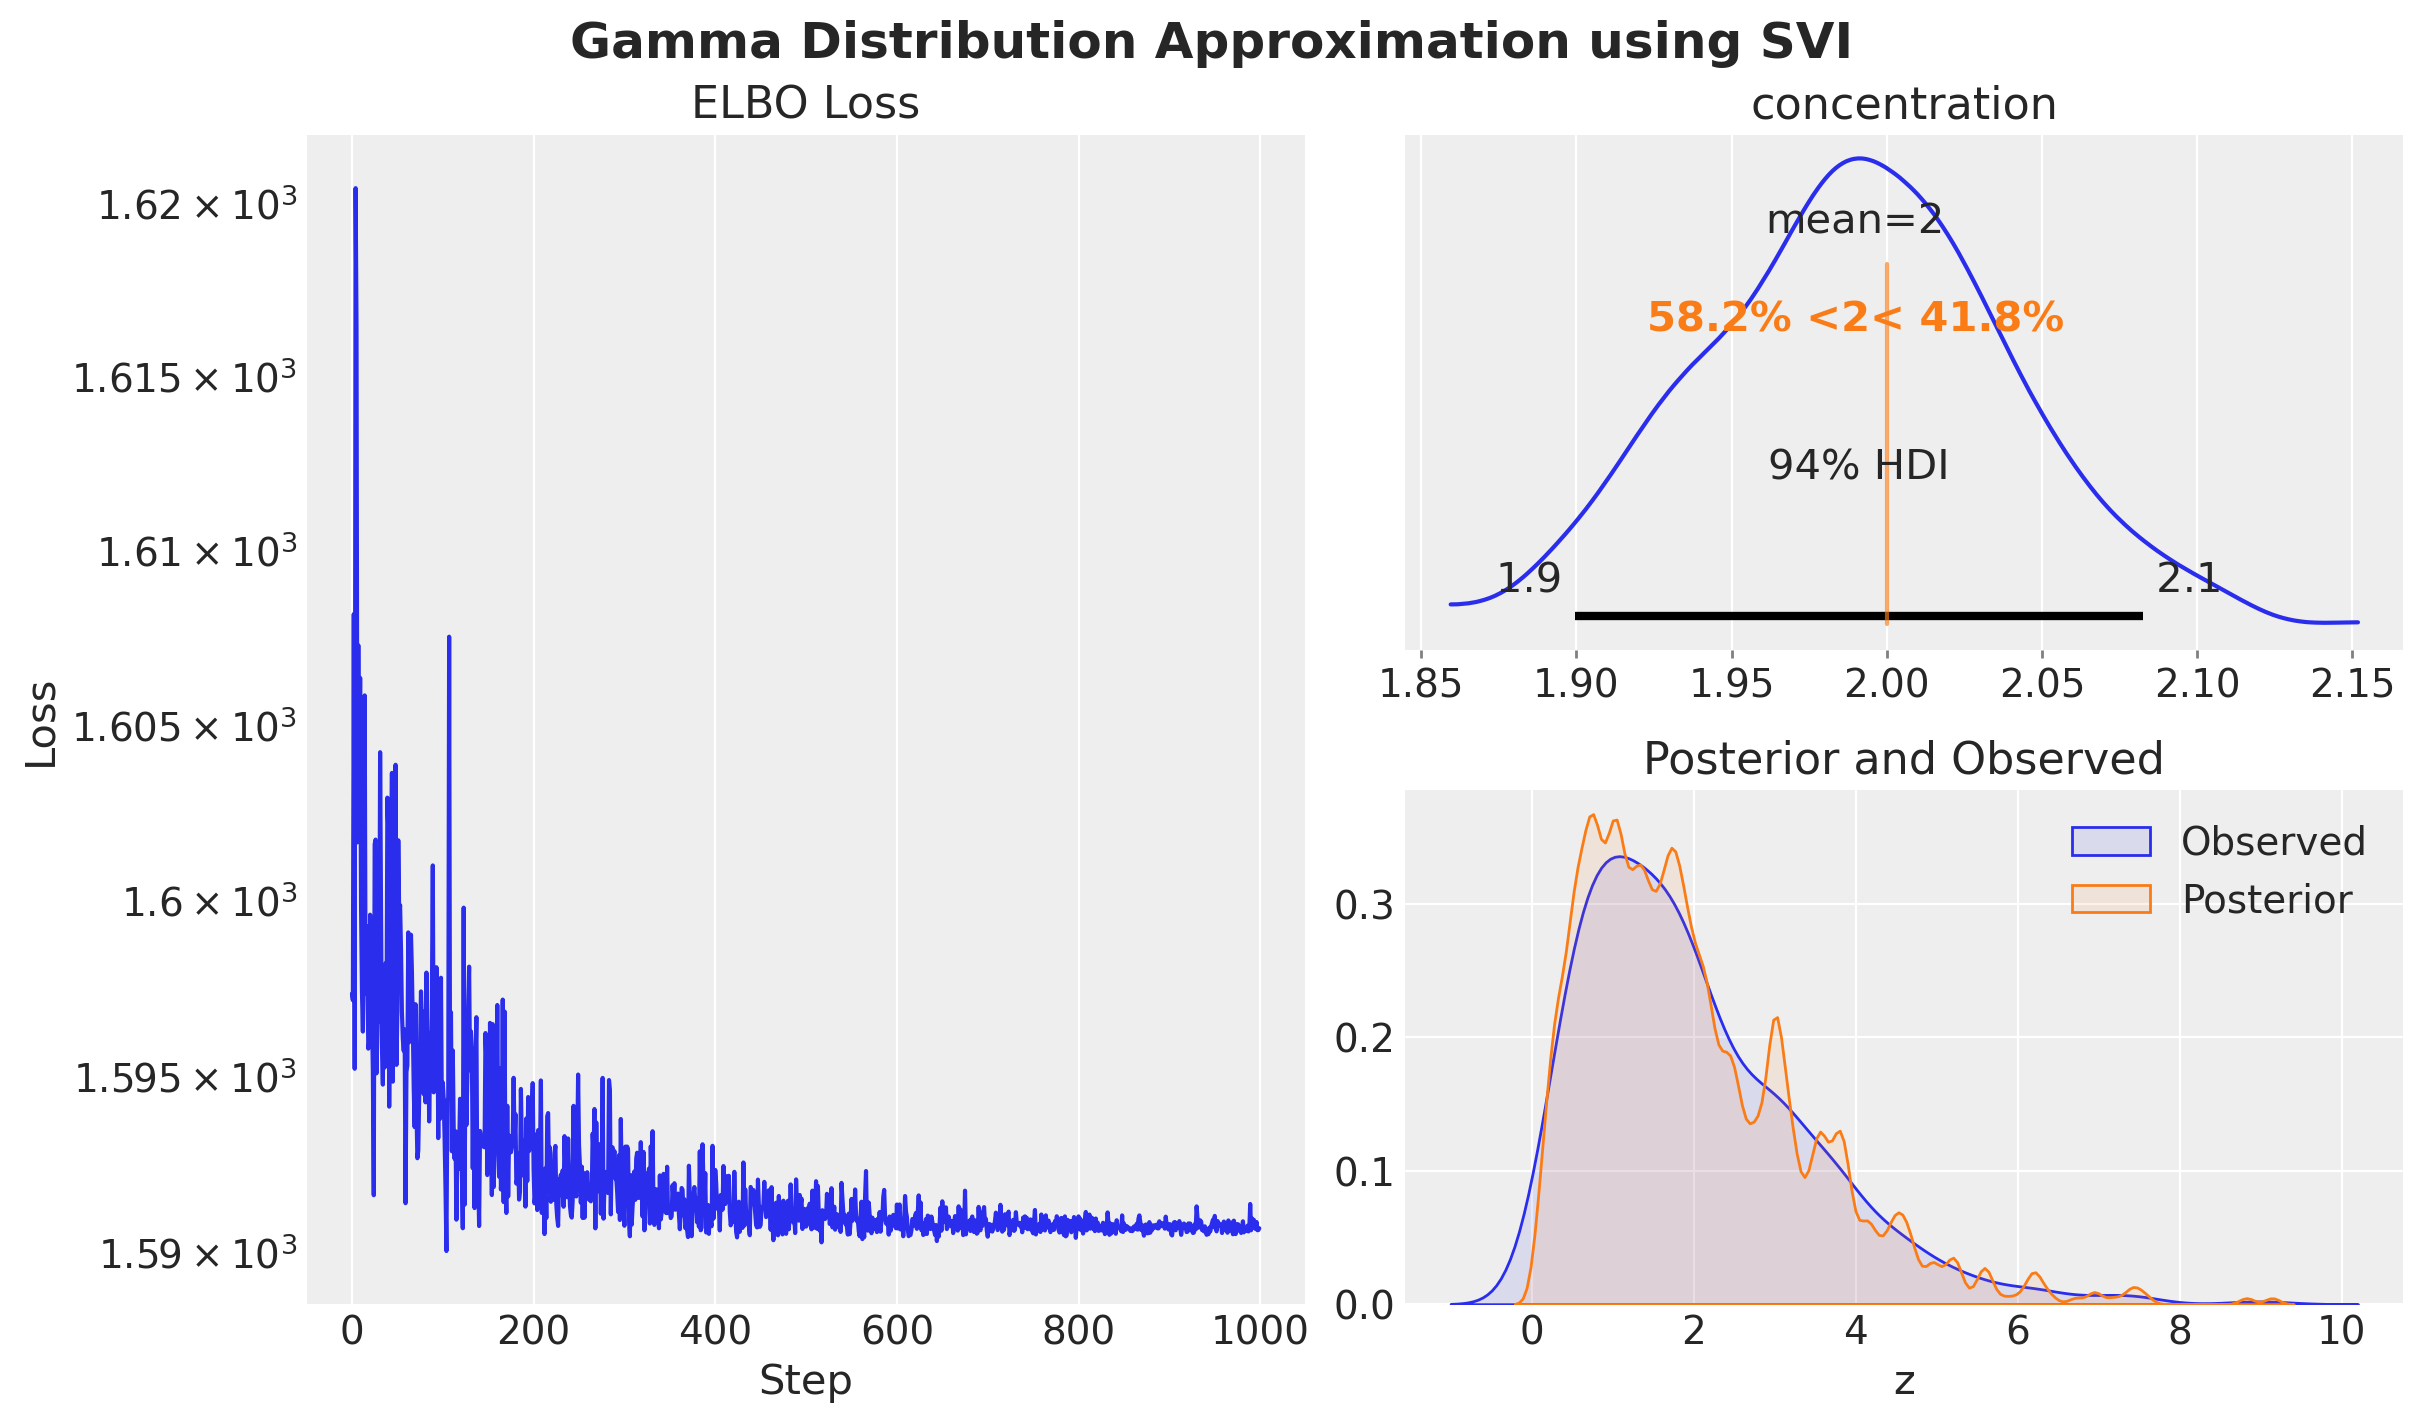

In [12]:
fig, axes = plt.subplot_mosaic(
    [["left", "upper right"], ["left", "lower right"]],
    figsize=(12, 7),
    layout="constrained",
)

axes["left"].plot(svi_result.losses)
axes["left"].set(yscale="log")
axes["left"].set(title="ELBO Loss", xlabel="Step", ylabel="Loss")
az.plot_posterior(
    idata, var_names=["concentration"], ref_val=concentration, ax=axes["upper right"]
)
sns.kdeplot(z, fill=True, alpha=0.1, label="Observed", ax=axes["lower right"])
sns.kdeplot(
    idata["posterior"]["z"].to_numpy().flatten(),
    color="C1",
    fill=True,
    alpha=0.1,
    label="Posterior",
    ax=axes["lower right"],
)
axes["lower right"].legend()
axes["lower right"].set(title="Posterior and Observed", xlabel="z", ylabel=None)
fig.suptitle(
    "Gamma Distribution Approximation using SVI", fontsize=18, fontweight="bold"
);

- In the left panel, we plot the ELBO loss as a function of the number of steps. As expected, the loss decreases as the number of steps increases.
- In the upper right panel, we plot the posterior distribution of the concentration parameter. We see that the posterior distribution is centered around the true value of the concentration parameter.
- In the lower right panel, we plot the posterior distribution of the data samples. It matches the observed data samples.

For the sake of comparison, let's inspect the results of the SVI algorithm using an AutoNormal guide.

In [13]:
svi_result.params

{'concentration_auto_loc': Array(0.6887781, dtype=float32),
 'concentration_auto_scale': Array(0.0238604, dtype=float32)}

Mmm, these look odd and very different from the previous results. Still, we know the approximation worked (see plot above). What is going on? Inside these auto-guides, the parameters are estimated in the unconstrained space (log scale). Hence, we need to transform them back to the original space to compare against we obtained above.
















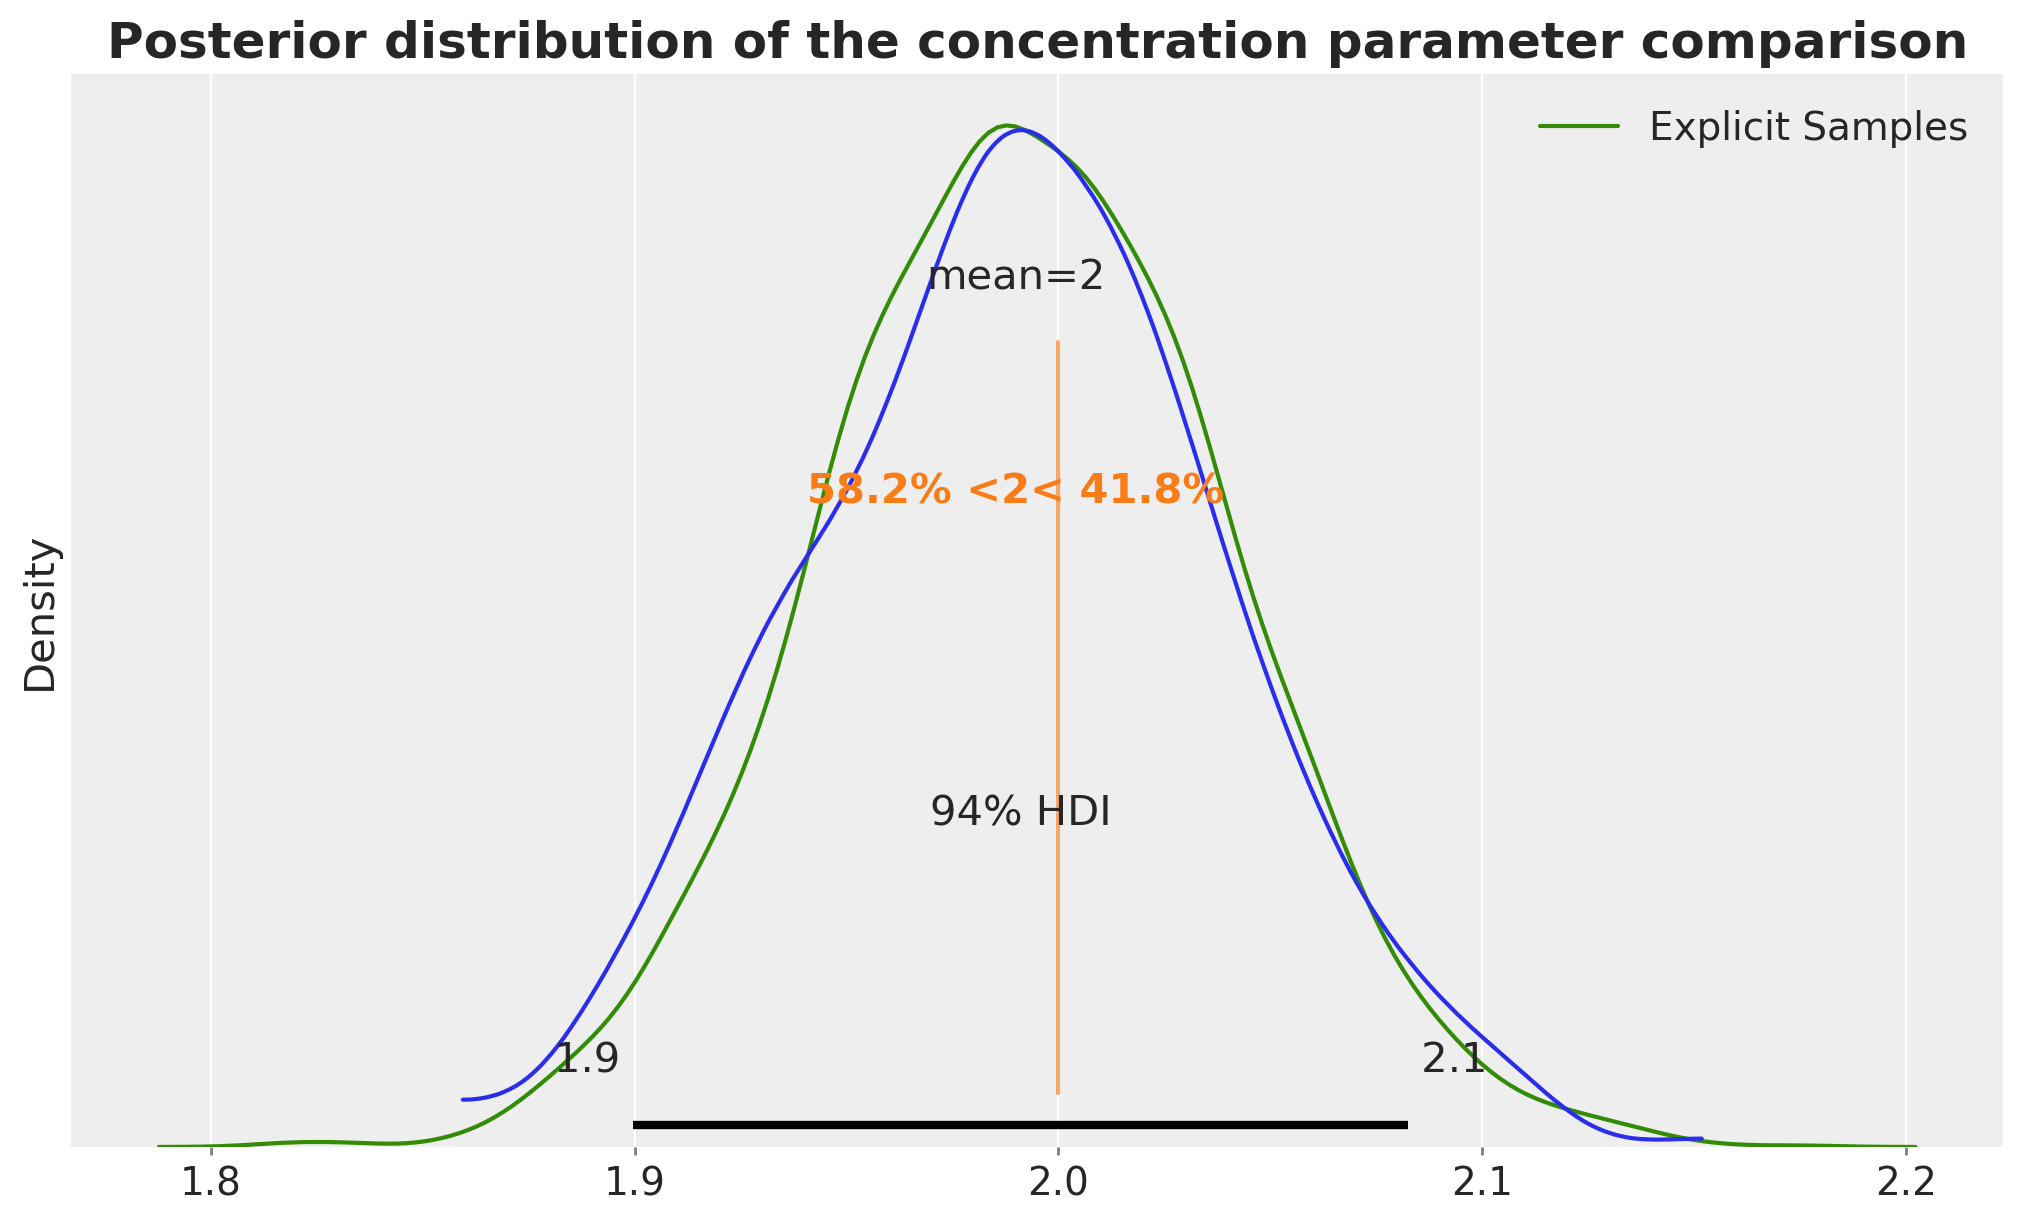

In [14]:
# Sample from a normal distribution from the learned parameters
# in the unconstrained space (log scale)
rng_key, rng_subkey = random.split(rng_key)
concentration_posterior_samples_log_scale = (
    svi_result.params["concentration_auto_loc"]
    + random.normal(rng_subkey, shape=(4_000,))
    * svi_result.params["concentration_auto_scale"]
)

# Transform back to the original space using the exponential function
concentration_posterior_samples = jnp.exp(concentration_posterior_samples_log_scale)

# Plot the posterior samples
fig, ax = plt.subplots()
sns.kdeplot(
    concentration_posterior_samples, color="C2", label="Explicit Samples", ax=ax
)
az.plot_posterior(
    idata,
    var_names=["concentration"],
    ref_val=concentration,
    ax=ax,
)
ax.legend()
ax.set_title(
    "Posterior distribution of the concentration parameter comparison",
    fontsize=18,
    fontweight="bold",
);

We obtained the expected result! Note that is use use the auto-guides and the [`Predictive`](https://num.pyro.ai/en/stable/utilities.html#predictive) function to generate the posterior samples you do not neet to worry about the forward pass or the transformation back to the original space.

Next, we move to a more interesting example.

## BNN Example: Generate Synthetic Data

In order to work with a well-known dataset, we will use the [two moons dataset from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).










In [15]:
# The moons dataset creates two interleaving half-moon shapes with controllable noise
n_samples = 2_000
x, y = make_moons(
    n_samples=n_samples,  # Total number of samples
    noise=0.25,  # Standard deviation of Gaussian noise added to data
    random_state=seed,  # For reproducible results
)

# First split: separate test set (20% of total)
x_train_all, x_test, y_train_all, y_test = train_test_split(
    x,
    y,
    test_size=0.3,  # 30% for testing
    random_state=seed,  # Reproducible split
)

# Second split: create validation set from remaining training data
# (30% of 70% = 21% of total)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all,
    y_train_all,
    test_size=0.3,  # 30% of remaining for validation
    random_state=seed,
)

# Calculate sample sizes for each split
n_train = x_train.shape[0]
n_val = x_val.shape[0]
n_test = x_test.shape[0]
n = n_train + n_val + n_test

print("Dataset sizes:")
print(f"  Training: {n_train} samples ({n_train / n:.1%})")
print(f"  Validation: {n_val} samples ({n_val / n:.1%})")
print(f"  Test: {n_test} samples ({n_test / n:.1%})")

# Convert to JAX arrays with explicit type annotations
# JAX arrays are immutable and can be compiled/optimized by JAX
x_train: Float[Array, "n_train 2"] = jnp.array(x_train)
x_val: Float[Array, "n_val 2"] = jnp.array(x_val)
x_test: Float[Array, "n_test 2"] = jnp.array(x_test)
y_train: Int[Array, "n_train"] = jnp.array(y_train)
y_val: Int[Array, "n_val"] = jnp.array(y_val)
y_test: Int[Array, "n_test"] = jnp.array(y_test)

# Create index ranges for each dataset split (useful for plotting and analysis)
idx_train = range(n_train)
idx_val = range(n_train, n_train + n_val)
idx_test = range(n_train + n_val, n_train + n_val + n_test)

Dataset sizes:
  Training: 980 samples (49.0%)
  Validation: 420 samples (21.0%)
  Test: 600 samples (30.0%)


Let's visualize our data to understand the classification challenge we're facing.

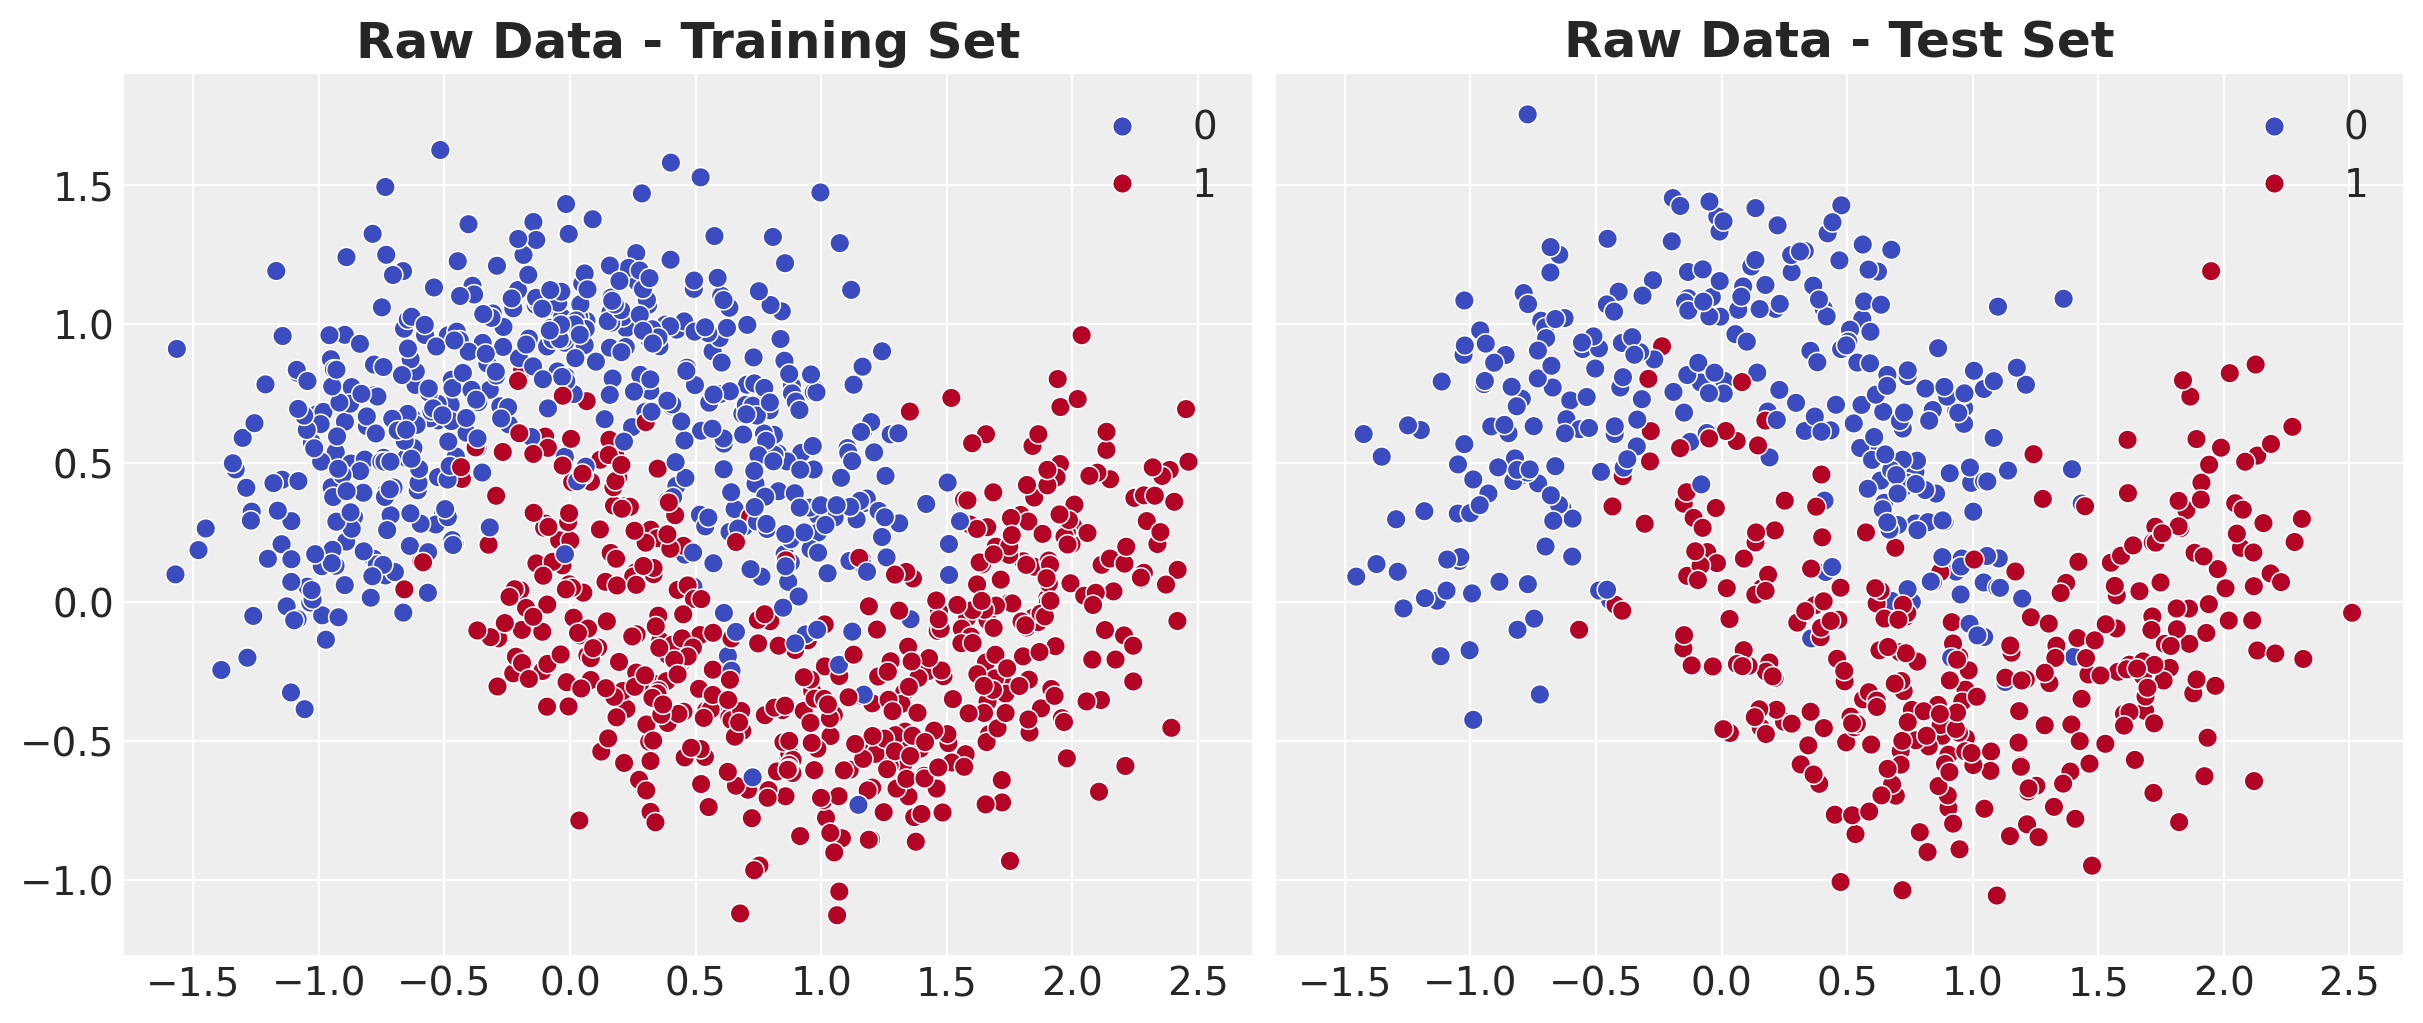

In [16]:
cmap = mpl.colormaps["coolwarm"]
colors = list(cmap(np.linspace(0, 1, 2)))

fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 5),
    sharex=True,
    sharey=True,
    layout="constrained",
)

sns.scatterplot(
    x=x_train[:, 0], y=x_train[:, 1], s=50, hue=y_train, palette=colors, ax=ax[0]
)
ax[0].set_title("Raw Data - Training Set", fontsize=18, fontweight="bold")

sns.scatterplot(
    x=x_test[:, 0], y=x_test[:, 1], s=50, hue=y_test, palette=colors, ax=ax[1]
)
ax[1].set_title("Raw Data - Test Set", fontsize=18, fontweight="bold");

**Observations:**
 - The data consists of two interleaving half-moon shapes
 - A linear classifier would fail completely on this dataset
 - We need a non-linear model to separate the classes

The idea is to develop a **Bayesian neural network classifier** that can:
1. Learn the non-linear decision boundary
2. Quantify uncertainty in its predictions

## Model Specification

### Bayesian Neural Networks (BNNs)

Unlike traditional neural networks with fixed weights, **Bayesian Neural Networks** place probability distributions over the weights. This allows us to:

1. **Quantify uncertainty**: Different weight samples lead to different predictions
2. **Avoid overfitting**: The prior acts as regularization
3. **Make calibrated predictions**: Output probabilities reflect true confidence

### Architecture Design

Our BNN architecture consists of:
- **Input layer**: 2 features (x, y coordinates from the two moons dataset)
- **Hidden layer 1**: 4 neurons with tanh activation
- **Hidden layer 2**: 3 neurons with tanh activation
- **Output layer**: 1 neuron with sigmoid activation (for binary classification probabilities)

**Prior distributions** over all network parameters:
- **Weights** $W_\ell$: $\text{SoftLaplace}(0, 1)$ - encourages sparsity and robust learning
- **Biases** $b_\ell$: $\text{Normal}(0, 1)$ - standard regularization with moderate spread

### Mathematical Formulation

**Forward pass through the network:**

Let $z_0 = x$ be the input features. For hidden layers $\ell = 1, 2$:
$$z_\ell = \tanh(W_\ell z_{\ell-1} + b_\ell)$$

where:
- $W_\ell \in \mathbb{R}^{d_{\ell-1} \times d_\ell}$ is the weight matrix for layer $\ell$
- $b_\ell \in \mathbb{R}^{d_\ell}$ is the bias vector for layer $\ell$
- $d_0 = 2$, $d_1 = 4$, $d_2 = 3$, $d_3 = 1$ are the layer dimensions

**Final output (classification probability):**
$$p(y=1|x, \theta) = \sigma(W_3 z_2 + b_3)$$

where

$$\sigma(t) = \frac{1}{1 + e^{-t}}$$

is the sigmoid function and $\theta = \{W_\ell, b_\ell\}_{\ell=1}^3$ represents all network parameters.

**Prior distributions:**
$$W_\ell \sim \text{SoftLaplace}(0, 1), \quad b_\ell \sim \text{Normal}(0, 1) \quad \text{for } \ell = 1, 2, 3$$

**Remark:** Thre is no real strong reason to use the SoftLaplace distribution for the weights. We could have used a Normal distribution, but we wanted to showcase the flexibility of the NumPyro library.

We use the Flax NNX library to define our neural network. 

**Remark:** It is great to see that JAX deep learning frameworks like [Flax](https://flax.readthedocs.io/en/latest/nnx_basics.html) and [Eqinox](https://docs.kidger.site/equinox/) are now integrated with NumPyro.


In [17]:
class MLP(nnx.Module):
    """
    Multi-Layer Perceptron implemented with Flax NNX.

    This class defines the architecture of our neural network using Flax NNX,
    which integrates seamlessly with NumPyro for Bayesian inference.

    Parameters
    ----------
    din : int
        Input dimension (number of features)
    dout : int
        Output dimension (1 for binary classification)
    hidden_layers : list of int
        List of hidden layer sizes
    rngs : nnx.Rngs
        Random number generator for parameter initialization
    """

    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ) -> None:
        self.layers = []

        # Create layer dimensions: [input_size, hidden1, hidden2, ..., output_size]
        layer_dims = [din, *hidden_layers, dout]

        # Build layers sequentially using pairwise iteration
        for in_dim, out_dim in pairwise(layer_dims):
            # Each layer is a linear transformation: y = Wx + b
            self.layers.append(nnx.Linear(in_dim, out_dim, rngs=rngs))

    def __call__(self, x: jax.Array) -> jax.Array:
        """
        Forward pass through the network.

        Parameters
        ----------
        x : jax.numpy.ndarray
            Input tensor of shape (batch_size, input_dim)

        Returns
        -------
        jax.numpy.ndarray
            Sigmoid-activated output for binary classification
        """
        # Apply tanh activation to all hidden layers
        for layer in self.layers[:-1]:
            x = jax.nn.tanh(layer(x))

        # Apply sigmoid to final layer for probability output
        return jax.nn.sigmoid(self.layers[-1](x))

Now we can initialize the neural network.

In [18]:
# Split random key for neural network initialization
rng_key, rng_subkey = random.split(rng_key)

# Define network architecture
# This creates a network with structure: 2 -> 4 -> 3 -> 1
hidden_layers = [4, 3]  # Hidden layer sizes only
dout = 1  # Output layer size

# Initialize the neural network module
nnx_module = MLP(
    din=x_train.shape[1],  # Input dimension (2 features)
    dout=dout,  # Output dimension (1 for binary classification)
    hidden_layers=hidden_layers,
    rngs=nnx.Rngs(rng_subkey),  # Flax NNX random number generator
)

print(
    f"""
    Total parameters: {
        sum(p.size for p in jax.tree_util.tree_leaves(nnx.state(nnx_module)))
    }
    """
)


    Total parameters: 31
    


We can now use this neural network architecture to define our Bayesian model.

In [19]:
def model(
    x: Float[Array, "n_obs features"], y: Int[Array, " n_obs"] | None = None
) -> None:
    """
    NumPyro model function defining the Bayesian Neural Network.

    This function specifies the generative process:
    1. Sample neural network parameters from priors
    2. Compute predictions via forward pass
    3. Sample observations from Bernoulli likelihood

    Parameters
    ----------
    x : Float[Array, "n_obs features"]
        Input features of shape (n_obs, 2)
    y : Int[Array, " n_obs"] or None, optional
        Target labels of shape (n_obs,). None during prediction.
    """
    n_obs: int = x.shape[0]  # Number of observations

    # Prior distribution factory for network parameters.
    def prior(name, shape):
        if "bias" in name:
            return dist.Normal(loc=0, scale=1)
        return dist.SoftLaplace(loc=0, scale=1)

    # Create a NumPyro-wrapped version of our neural network
    # This automatically assigns priors to all parameters
    nn = random_nnx_module(
        "nn",  # Name prefix for all parameters
        nnx_module,  # Our Flax NNX module
        prior=prior,  # Prior distribution factory
    )

    # Forward pass: compute probabilities for each observation
    # squeeze(-1) removes the last dimension to get shape (n_obs,)
    p = numpyro.deterministic("p", nn(x).squeeze(-1))

    # Likelihood: each label is drawn from a Bernoulli distribution
    # numpyro.plate creates conditional independence across observations
    with numpyro.plate("data", n_obs):
        numpyro.sample("y", dist.Bernoulli(probs=p), obs=y)

Let's visualize the model structure:

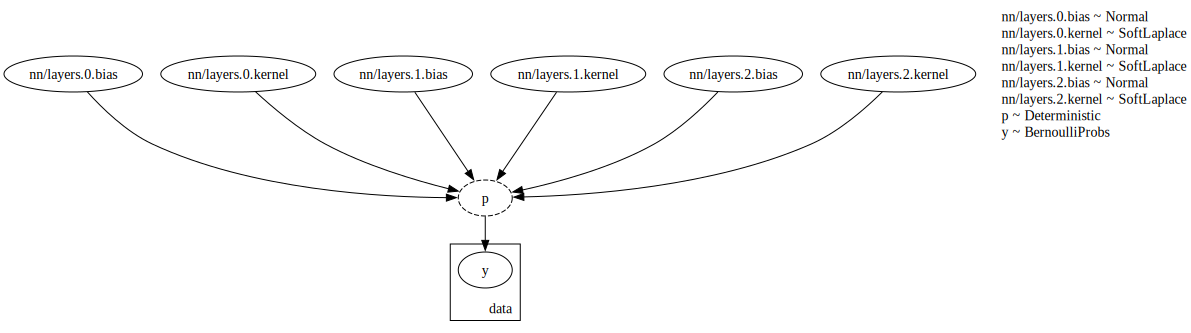

In [20]:
# Test the model by rendering its structure
numpyro.render_model(
    model=model,
    model_kwargs={"x": x_train},  # Pass training data for shape inference
    render_distributions=True,  # Show distribution details
    render_params=True,  # Show parameter nodes
)

Now that we have defined our model, we can start looking into the estimation of the model parameters.

## Prior Predictive Analysis

Before we start the training, we can compute the prior predictive distribution of the model. This will give us an idea of what the model is expected to do before we start the trainin.

In [21]:
# Create prior predictive sampler for training data
prior_predictive = Predictive(
    model=model,  # Our BNN model
    num_samples=2_000,  # Number of posterior samples to draw
    return_sites=["p", "y"],  # Return both probabilities and predictions
)

# Generate samples for training data
rng_key, rng_subkey = random.split(key=rng_key)
prior_predictive_samples = prior_predictive(rng_subkey, x_train)

# Convert to ArviZ InferenceData for analysis and visualization
prior_predictive_idata = az.from_dict(
    posterior_predictive={
        # Add chain dimension for ArviZ compatibility
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in prior_predictive_samples.items()
    },
    coords={"obs_idx": idx_train},  # Coordinate labels for observations
    dims={
        "p": ["obs_idx"],  # Probability predictions
        "y": ["obs_idx"],  # Binary predictions
    },
)

Let's visualize the prior predictive distribution of the model through two lenses:

1. **Prior Predictive Mean Predictions**: This will give us an idea of what the model is expected to do before we start the training.
2. **Prior Predictive HDI Width**: This will give us an idea of the uncertainty of the model before we start the training. We use the highest density interval (HDI) to quantify the uncertainty.

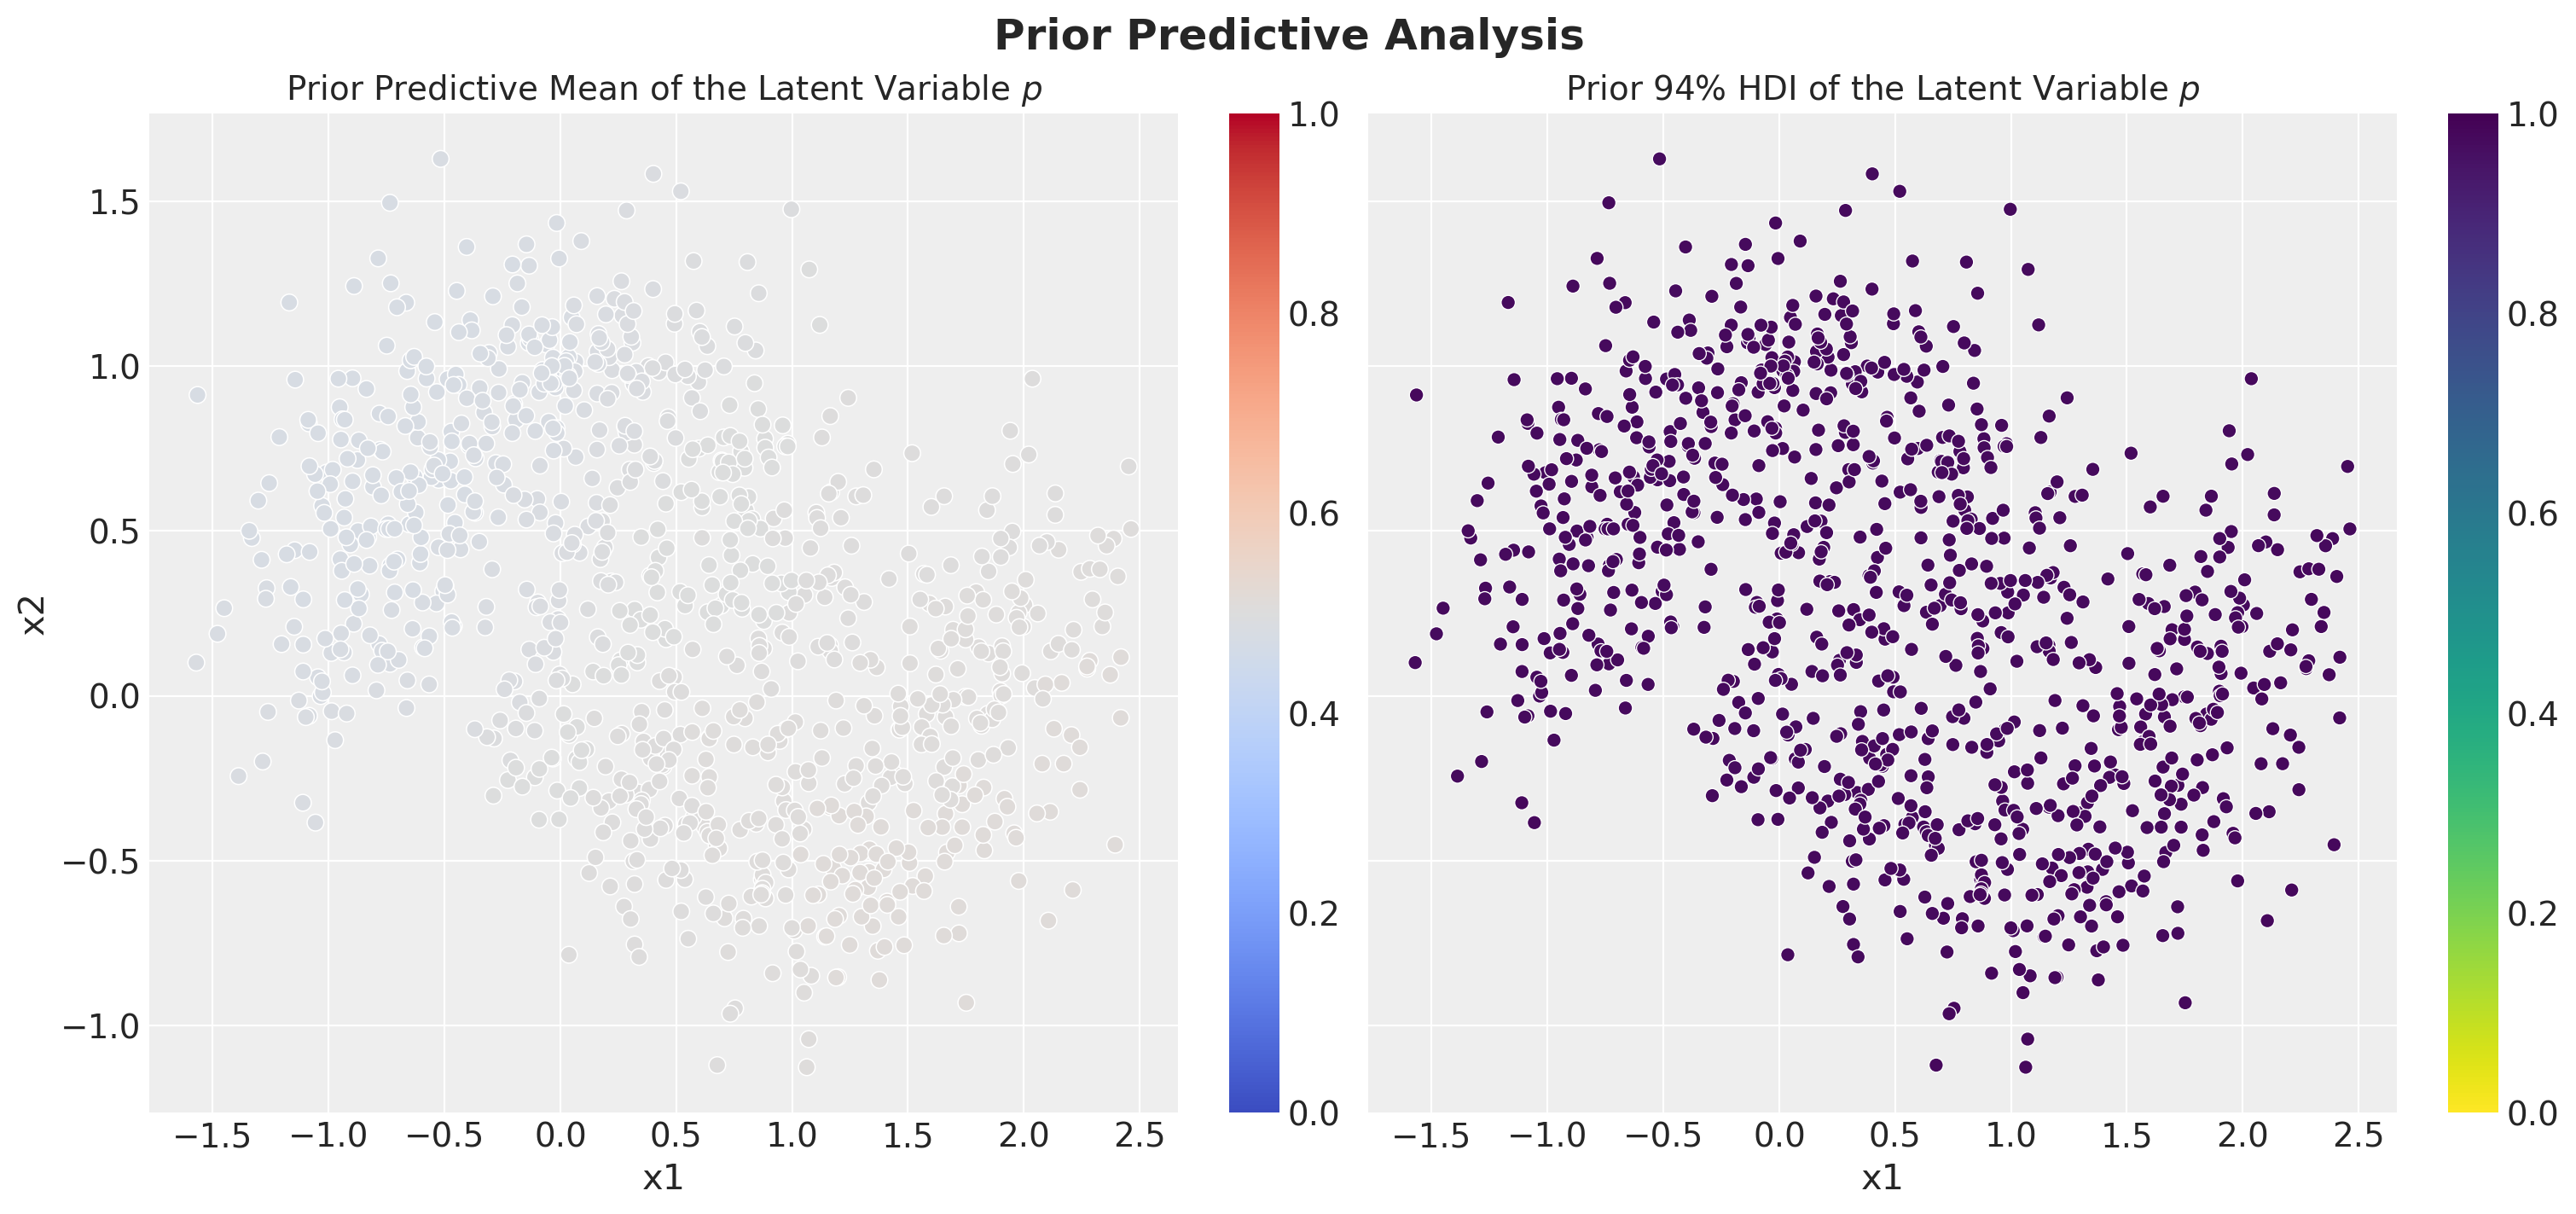

In [22]:
# HDI of the posterior predictive distribution
prior_predictive_p_hdi = az.hdi(
    prior_predictive_idata["posterior_predictive"]["p"], hdi_prob=0.94
)
# Compute the width of the HDI
prior_predictive_hdi_width = prior_predictive_p_hdi.sel(
    hdi="higher"
) - prior_predictive_p_hdi.sel(hdi="lower")


fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

(
    prior_predictive_idata["posterior_predictive"]["p"]
    .mean(dim=("chain", "draw"))
    .to_pandas()
    .to_frame()
    .assign(x1=x_train[:, 0], x2=x_train[:, 1])
    .pipe(
        (sns.scatterplot, "data"),
        x="x1",
        y="x2",
        hue="p",
        hue_norm=(0, 1),
        palette="coolwarm",
        s=50,
        ax=ax[0],
    )
)
mappable = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(mappable, ax=ax[0])

ax[0].legend().remove()
ax[0].set_title("Prior Predictive Mean of the Latent Variable $p$", fontsize=14)

(
    prior_predictive_hdi_width.rename({"p": "hdi_width"})
    .to_pandas()
    .assign(x1=x_train[:, 0], x2=x_train[:, 1])
    .pipe(
        (sns.scatterplot, "data"),
        x="x1",
        y="x2",
        hue="hdi_width",
        hue_norm=(0, 1),
        palette="viridis_r",
        ax=ax[1],
    )
)
mappable = plt.cm.ScalarMappable(cmap="viridis_r", norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(mappable, ax=ax[1])

ax[1].legend().remove()
ax[1].set_title(r"Prior $94\%$ HDI of the Latent Variable $p$", fontsize=14)
fig.suptitle("Prior Predictive Analysis", fontsize=18, fontweight="bold");

From these plots we see that, before conditioning on the data, the model has no strong prior constraints on the latent variable $p$.

## The Guide Function (Variational Approximation)

Recall that the SVI idea is to convert the sampling problem into an optimization problem. To do so, we need to parametrize our approximation.
The **guide function** defines our variational approximation to the posterior. Instead of the complex true posterior $p(\theta|D)$, we use a simpler family of distributions $q_\phi(\theta)$.

### Mean-Field Variational Approximation

We assume **mean-field independence**: each parameter has its own independent (Normal or SoftLaplace, in this example) distribution:

$$q_\phi(\theta) = \prod_i q_{\phi_i}(\theta_i)$$

Where each $q_{\phi_i}$ is parameterized by:
- **Location parameter** $\mu_i$ (learnable)
- **Scale parameter** $\sigma_i$ (learnable, constrained to be positive)

### The Mean-Field Assumption: Benefits and Limitations

This factorization assumption dramatically simplifies the optimization landscape. Instead of searching over the space of all possible multivariate distributions, we restrict ourselves to products of univariate distributions.

**Theoretical Limitations:**
- **Posterior correlations**: The approximation cannot capture correlations between parameters
- **Multimodality**: Mean-field approximations struggle with multimodal posteriors
- **Underestimation of uncertainty**: The independence assumption typically leads to overconfident (too narrow) posterior approximations

Despite these limitations, mean-field VI often provides excellent approximations for many practical problems, especially when the true posterior is reasonably close to unimodal and when parameter correlations are not too strong.

NumPyro provides a very convenient way to generate guides automatically. For example, the following code generates a guide for the model we defined above:

```python
from numpyro.infer.autoguide import AutoNormal

guide = AutoNormal(model)
```

For all of the applications, this is a great starting point. There are many ways to mix guides, see for example the [`AutoGuideList`](https://num.pyro.ai/en/latest/autoguide.html#numpyro.infer.autoguide.AutoGuideList) (among [others](https://num.pyro.ai/en/stable/autoguide.html)).

For this example, just for the sake of illustration, we will use write our own guide function.

**Remark:** In most of the applications, I would not recommend starting with a custom guide. The reason is that you need to be careful with the variable names, parametrizations, contrains, etc. Also, as the model gets more complex, it is easy to make mistakes.

As we are using a BNN, we need to define the guide function for each of the layers.

In [23]:
def layer_guide(
    loc_shape: tuple[int, ...],
    loc_amplitude: float,
    scale_shape: tuple[int, ...],
    scale_amplitude: float,
    loc_name: str,
    scale_name: str,
    layer_name: str,
    event_shape: int = 1,
    seed: int = 42,
) -> None:
    """
    Create a variational approximation for a single layer's parameters.

    This function defines the guide (variational approximation) for one layer's
    weights or biases. It creates learnable location and scale parameters for
    either Normal or SoftLaplace distributions.

    Parameters
    ----------
    loc_shape : tuple of int
        Shape of the location (mean) parameters
    loc_amplitude : float
        Initialization scale for location parameters
    scale_shape : tuple of int
        Shape of the scale (std) parameters
    scale_amplitude : float
        Initialization scale for scale parameters
    loc_name : str
        Parameter name for location
    scale_name : str
        Parameter name for scale
    layer_name : str
        Name of the layer (used to choose distribution type)
    event_shape : int, optional
        Dimensionality for to_event() transformation, by default 1
    seed : int, optional
        Random seed for reproducible initialization, by default 42
    """
    # Create local random key for this layer
    rng_key = random.PRNGKey(seed)

    # Initialize location parameters with random values
    rng_key, rng_subkey = random.split(rng_key)
    # As for general neural networks, we need to initialize the parameters.
    # It is recommended to initialize the parameters at random.
    # Here we do it for the location parameters.
    loc = numpyro.param(
        loc_name, loc_amplitude * random.uniform(rng_subkey, shape=loc_shape)
    )

    # We do the same for the scale parameters.
    rng_key, rng_subkey = random.split(rng_key)
    scale = numpyro.param(
        scale_name,
        scale_amplitude * random.uniform(rng_subkey, shape=scale_shape),
        constraint=dist.constraints.positive,  # Ensure scale > 0
    )

    # Choose distribution type based on layer name
    if "bias" in layer_name:
        # Bias parameters use Normal distribution (matching model prior)
        numpyro.sample(
            layer_name,
            dist.Normal(loc=loc, scale=scale).to_event(event_shape),
        )
    else:
        # Weight parameters use SoftLaplace distribution (matching model prior)
        numpyro.sample(
            layer_name,
            dist.SoftLaplace(loc=loc, scale=scale).to_event(event_shape),
        )


def guide(
    x: Float[Array, "n_obs features"], y: Int[Array, " n_obs"] | None = None
) -> None:
    """
    Variational guide function that approximates the posterior distribution.

    This function defines the variational family q_φ(θ) that approximates
    the true posterior p(θ|data). We use mean-field independence with
    separate Normal/SoftLaplace distributions for each parameter.

    Parameters
    ----------
    x : Float[Array, "n_obs features"]
        Input features (same as model, but may not be used in guide)
    y : Int[Array, " n_obs"] or None, optional
        Target labels (same as model, but may not be used in guide)
    """
    output_dim = 1  # Output dimension

    # Create variational approximations for all bias parameters
    # Biases have shape (layer_size,) so event_shape=1
    for i, hl in enumerate([*hidden_layers, output_dim]):
        layer_guide(
            loc_shape=(hl,),  # Bias vector shape
            loc_amplitude=1.0,  # Initialize around [-1, 1]
            scale_shape=(hl,),  # One scale per bias
            scale_amplitude=1.0,  # Initialize scales around [0, 1]
            loc_name=f"nn/layers.{i}.bias_auto_loc",  # NumPyro parameter name
            scale_name=f"nn/layers.{i}.bias_auto_scale",  # NumPyro parameter name
            layer_name=f"nn/layers.{i}.bias",  # Layer parameter name
            event_shape=1,  # Vector parameter
            seed=42 + i,  # Unique seed per layer
        )

    # Create variational approximations for all weight parameters
    # Weights have shape (input_size, output_size) so event_shape=2
    for j, (hl_in, hl_out) in enumerate(
        pairwise([x.shape[1], *hidden_layers, output_dim])
    ):
        layer_guide(
            loc_shape=(hl_in, hl_out),  # Weight matrix shape
            loc_amplitude=1.0,  # Initialize around [-1, 1]
            scale_shape=(hl_in, hl_out),  # One scale per weight
            scale_amplitude=1.0,  # Initialize scales around [0, 1]
            loc_name=f"nn/layers.{j}.kernel_auto_loc",  # NumPyro parameter name
            scale_name=f"nn/layers.{j}.kernel_auto_scale",  # NumPyro parameter name
            layer_name=f"nn/layers.{j}.kernel",  # Layer parameter name
            event_shape=2,  # Matrix parameter
            seed=1 + j,  # Unique seed per layer
        )

Here are some relevant tips and trikcs to implement guides from the Pyro documentation [SVI Part IV: Tips and Tricks](https://pyro.ai/examples/svi_part_iv.html):

- 6. [If you are having trouble constructing a custom guide, use an AutoGuide](https://pyro.ai/examples/svi_part_iv.html#6.-If-you-are-having-trouble-constructing-a-custom-guide,-use-an-AutoGuide)
- 7. [Parameter initialization matters: initialize guide distributions to have low variance](https://pyro.ai/examples/svi_part_iv.html#7.-Parameter-initialization-matters:-initialize-guide-distributions-to-have-low-variance). This was an important advice to make the guide above work.

## SVI Training Setup

Now that we have our model and guide function, we can define the SVI training setup. Here we give a brief overview of the optimization setup.

### The ELBO: Our Optimization Target

SVI maximizes the Evidence Lower BOund (ELBO), which provides a tractable lower bound on the log marginal likelihood. Using our established notation, the ELBO can be written in the standard form:

$$\text{ELBO}(\phi) = \mathbb{E}_{q_\phi(\theta)}[\log p(y|x, \theta)] - \text{KL}[q_\phi(\theta) \| p(\theta)]$$

This formulation clearly shows the two competing objectives:
- **Reconstruction term** $\mathbb{E}_{q_\phi(\theta)}[\log p(y|x, \theta)]$: Rewards the model for explaining the observed data well
- **KL regularization** $\text{KL}[q_\phi(\theta) \| p(\theta)]$: Penalizes the approximate posterior for deviating from the prior

### The Gradient Estimation Challenge

The key computational challenge in SVI is estimating gradients of the ELBO with respect to the variational parameters $\phi$. The reconstruction term involves an expectation over the variational distribution, which we need to differentiate:

$$\nabla_\phi \mathbb{E}_{q_\phi(\theta)}[\log p(y|x, \theta)]$$

We can't simply move the gradient inside the expectation because $q_\phi(\theta)$ depends on $\phi$. This is where the **reparameterization trick** becomes crucial. For distributions like $\text{Normal}(\mu_\phi, \sigma_\phi^2)$, we can write:

$$\theta = \mu_\phi + \sigma_\phi \cdot \varepsilon, \quad \varepsilon \sim \text{Normal}(0, I)$$

This transforms the stochastic gradient into a deterministic one:

$$\nabla_\phi \mathbb{E}_{\epsilon}[\log p(y|x, g_\phi(\varepsilon))]$$

where $g_\phi(\varepsilon) = \mu_\phi + \sigma_\phi \cdot \varepsilon$. Now we can use Monte Carlo estimation with low variance by sampling $\varepsilon$ and computing gradients through the deterministic function $g_\phi$.

To do this in NumPyro, we can simply use the following code flow:

```python
import numpyro
from jax import random
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal

# Define the model
def model(*args, **kwargs):
   ...

# Define the guide function
guide = AutoNormal(model)

# Define the optimizer
optimizer = numpyro.optim.Adam(step_size=0.01)  # <- We need to specify the step size (learning rate)
# Initialize the SVI object
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

# Define the number of samples
n_samples = 5_000

# Initialize the random key
rng_key, rng_subkey = random.split(key=rng_key)

# Run the SVI
svi_result = svi.run(rng_subkey, n_samples, x_train_scaled, y_train_scaled)
```

This workflow is very easy to implement and should always be the first thing you try.

In this notebook, we will use a more sophisticated optimization setup and we will go deeper into the details of the optimization process to understand better what is happening behind the scenes so that we can add customizations like early stopping.

### Optimization Strategy

Instead of using just the classic Adam optimizer, we'll use a sophisticated optimization setup with:

1. **OneCycle Learning Rate Schedule**:
   - Starts low, increases to peak, then decreases
   - Helps escape local minima and achieve better convergence

2. **Adam Optimizer**:
   - Adaptive learning rates for each parameter
   - Good for training neural networks
   - Combines momentum with adaptive step sizes

3. **Reduce on Plateau**:
   - Automatically reduces learning rate when loss plateaus
   - Helps with fine-tuning in later stages

4. **Early Stopping**:
   - Monitors validation loss to prevent overfitting
   - Stops training when validation performance degrades

Again, from the tips and tricks section of the Pyro documentation:

- 1. [Start with a small learning rate](https://pyro.ai/examples/svi_part_iv.html#1.-Start-with-a-small-learning-rate)
- 2. [Use Adam or ClippedAdam by default](https://pyro.ai/examples/svi_part_iv.html#2.-Use-Adam-or-ClippedAdam-by-default)
- 3. [Consider using a decaying learning rate](https://pyro.ai/examples/svi_part_iv.html#3.-Consider-using-a-decaying-learning-rate)

Let's start by defining the optimizer and initializing the SVI object.

In [24]:
# Configure the learning rate scheduler
# OneCycle schedule: low -> high -> low with specific timing
scheduler = optax.linear_onecycle_schedule(
    transition_steps=8_000,  # Total number of optimization steps
    peak_value=0.008,  # Maximum learning rate (reached at pct_start)
    pct_start=0.008,  # Percent of training to reach peak (0.8%)
    pct_final=0.8,  # Percent of training for final phase (80%)
    div_factor=3,  # Initial LR = peak_value / div_factor
    final_div_factor=4,  # Final LR = initial_LR / final_div_factor
)

# Chain multiple optimizers for sophisticated training
optimizer = optax.chain(
    # Primary optimizer: Adam with scheduled learning rate
    optax.adam(learning_rate=scheduler),
    # Secondary optimizer: Reduce LR when loss plateaus
    optax.contrib.reduce_on_plateau(
        factor=0.1,  # Multiply LR by 0.1 when plateau detected
        patience=10,  # Wait 10 evaluations before reducing
        accumulation_size=100,  # Window size for detecting plateaus
    ),
)

# Create the SVI object that coordinates model, guide, optimizer, and loss
svi = SVI(
    model=model,  # Our BNN model
    guide=guide,  # Our variational approximation
    optim=optimizer,  # Optimization algorithm
    loss=Trace_ELBO(),  # ELBO loss function
)

# Initialize SVI state with random parameters
rng_key, rng_subkey = random.split(key=rng_key)
svi_state = svi.init(rng_subkey, x=x_train, y=y_train)

### Training Loop Implementation

Next, we are going to implement the training loop for optimization. In essence, we are reproducing and modifying what the [`svi.run`](https://num.pyro.ai/en/stable/_modules/numpyro/infer/svi.html#SVI.run) method does internally. This should resemble classical routines like gradient descent, if you are familiar with machine learning. In this setting, our training loop includes several important components:

1. Define the update setp of the SVI procedure. This will be handled internally by NumPyro under the method [`svi.update`](https://num.pyro.ai/en/stable/_modules/numpyro/infer/svi.html#SVI.update) (or [`svi.stable_update`](https://num.pyro.ai/en/stable/_modules/numpyro/infer/svi.html#SVI.stable_update)).
2. Define functions to compute the loss and the validation loss.
3. Define the training loop. This alternates between:
    - **Forward pass**: Compute ELBO loss on training data
    - **Backward pass**: Update variational parameters via gradients
    - **Validation**: Evaluate performance on held-out validation set
4. Define the progress tracking.

**Remark:** We use **JAX compilation** via [`jax.jit`](https://docs.jax.dev/en/latest/_autosummary/jax.jit.html#jax.jit) for fast execution.

In [25]:
%%time


# Define functions for efficient training loop execution
def body_fn(svi_state, _):
    """
    Single training step: compute gradients and update parameters.

    Parameters
    ----------
    svi_state : numpyro.infer.svi.SVIState
        Current SVI state containing parameters and optimizer state
    _ : Any
        Unused (for scan compatibility)

    Returns
    -------
    tuple
        Updated SVI state and training loss
    """
    svi_state, loss = svi.update(svi_state, x=x_train, y=y_train)
    return svi_state, loss


def get_val_loss(svi_state, x_val, y_val):
    """
    Compute validation loss without updating parameters.

    Parameters
    ----------
    svi_state : numpyro.infer.svi.SVIState
        Current SVI state
    x_val : jax.numpy.ndarray
        Validation features
    y_val : jax.numpy.ndarray
        Validation labels

    Returns
    -------
    jax.numpy.ndarray
        Validation ELBO loss
    """
    _, rng_subkey = random.split(svi_state.rng_key)
    params = svi.get_params(svi_state)  # Extract current parameter values

    # Compute loss without gradients or parameter updates
    return svi.loss.loss(
        rng_subkey,
        params,
        svi.model,  # Model function
        svi.guide,  # Guide function
        x=x_val,
        y=y_val,
    )


# Training configuration
num_steps = 8_000  # Maximum number of training steps
patience = 200  # Early stopping patience (steps)

# Storage for loss tracking
train_losses = []  # Raw training losses
norm_train_losses = []  # Training losses normalized by dataset size
val_losses = []  # Raw validation losses
norm_val_losses = []  # Validation losses normalized by dataset size

print("Starting SVI training...")
print(f"Max steps: {num_steps}")
print(f"Early stopping patience: {patience}")
print(f"Training set size: {n_train}")
print(f"Validation set size: {n_val}")

# Main training loop with progress bar
with tqdm.trange(1, num_steps + 1) as t:
    batch = max(num_steps // 20, 1)  # Batch size for progress updates
    patience_counter = 0  # Counter for early stopping

    for i in t:
        # Perform one training step (JIT compiled for speed)
        svi_state, train_loss = jax.jit(body_fn)(svi_state, None)

        # Normalize loss by dataset size for fair comparison
        norm_train_loss = jax.device_get(train_loss) / y_train.shape[0]
        train_losses.append(jax.device_get(train_loss))
        norm_train_losses.append(norm_train_loss)

        # Compute validation loss (JIT compiled for speed)
        val_loss = jax.jit(get_val_loss)(svi_state, x_val, y_val)
        norm_val_loss = jax.device_get(val_loss) / y_val.shape[0]
        val_losses.append(jax.device_get(val_loss))
        norm_val_losses.append(norm_val_loss)

        # Early stopping logic: stop if validation loss > training loss consistently
        condition = norm_val_loss > norm_train_loss
        patience_counter = patience_counter + 1 if condition else 0

        if patience_counter >= patience:
            print(
                f"Early stopping at step {i} (validation loss exceeding training loss)"
            )
            break

        # Update progress bar with recent average losses
        if i % batch == 0:
            avg_train_loss = sum(train_losses[i - batch :]) / batch
            avg_val_loss = sum(val_losses[i - batch :]) / batch

            t.set_postfix_str(
                f"train: {avg_train_loss:.4f}, val: {avg_val_loss:.4f}",
                refresh=False,
            )

# Convert loss lists to JAX arrays for efficient computation
train_losses = jnp.stack(train_losses)
val_losses = jnp.stack(val_losses)

# Create result object containing final parameters and training history
svi_result = SVIRunResult(
    params=svi.get_params(svi_state),  # Final optimized parameters
    state=svi_state,  # Final SVI state
    losses=train_losses,  # Training loss history
)

print(f"\nTraining completed after {len(train_losses)} steps")
print(f"Final training loss: {train_losses[-1]:.4f}")
print(f"Final validation loss: {val_losses[-1]:.4f}")

Starting SVI training...
Max steps: 8000
Early stopping patience: 200
Training set size: 980
Validation set size: 420


 37%|███▋      | 2995/8000 [00:02<00:03, 1375.03it/s, train: 234.4455, val: 125.3342]


Early stopping at step 2996 (validation loss exceeding training loss)

Training completed after 2996 steps
Final training loss: 237.7118
Final validation loss: 127.5784
CPU times: user 5.26 s, sys: 323 ms, total: 5.59 s
Wall time: 2.47 s


Obserseve we stoped the training before than expected becuase of the early stopping logic. Let's visualize the training and validation losses.

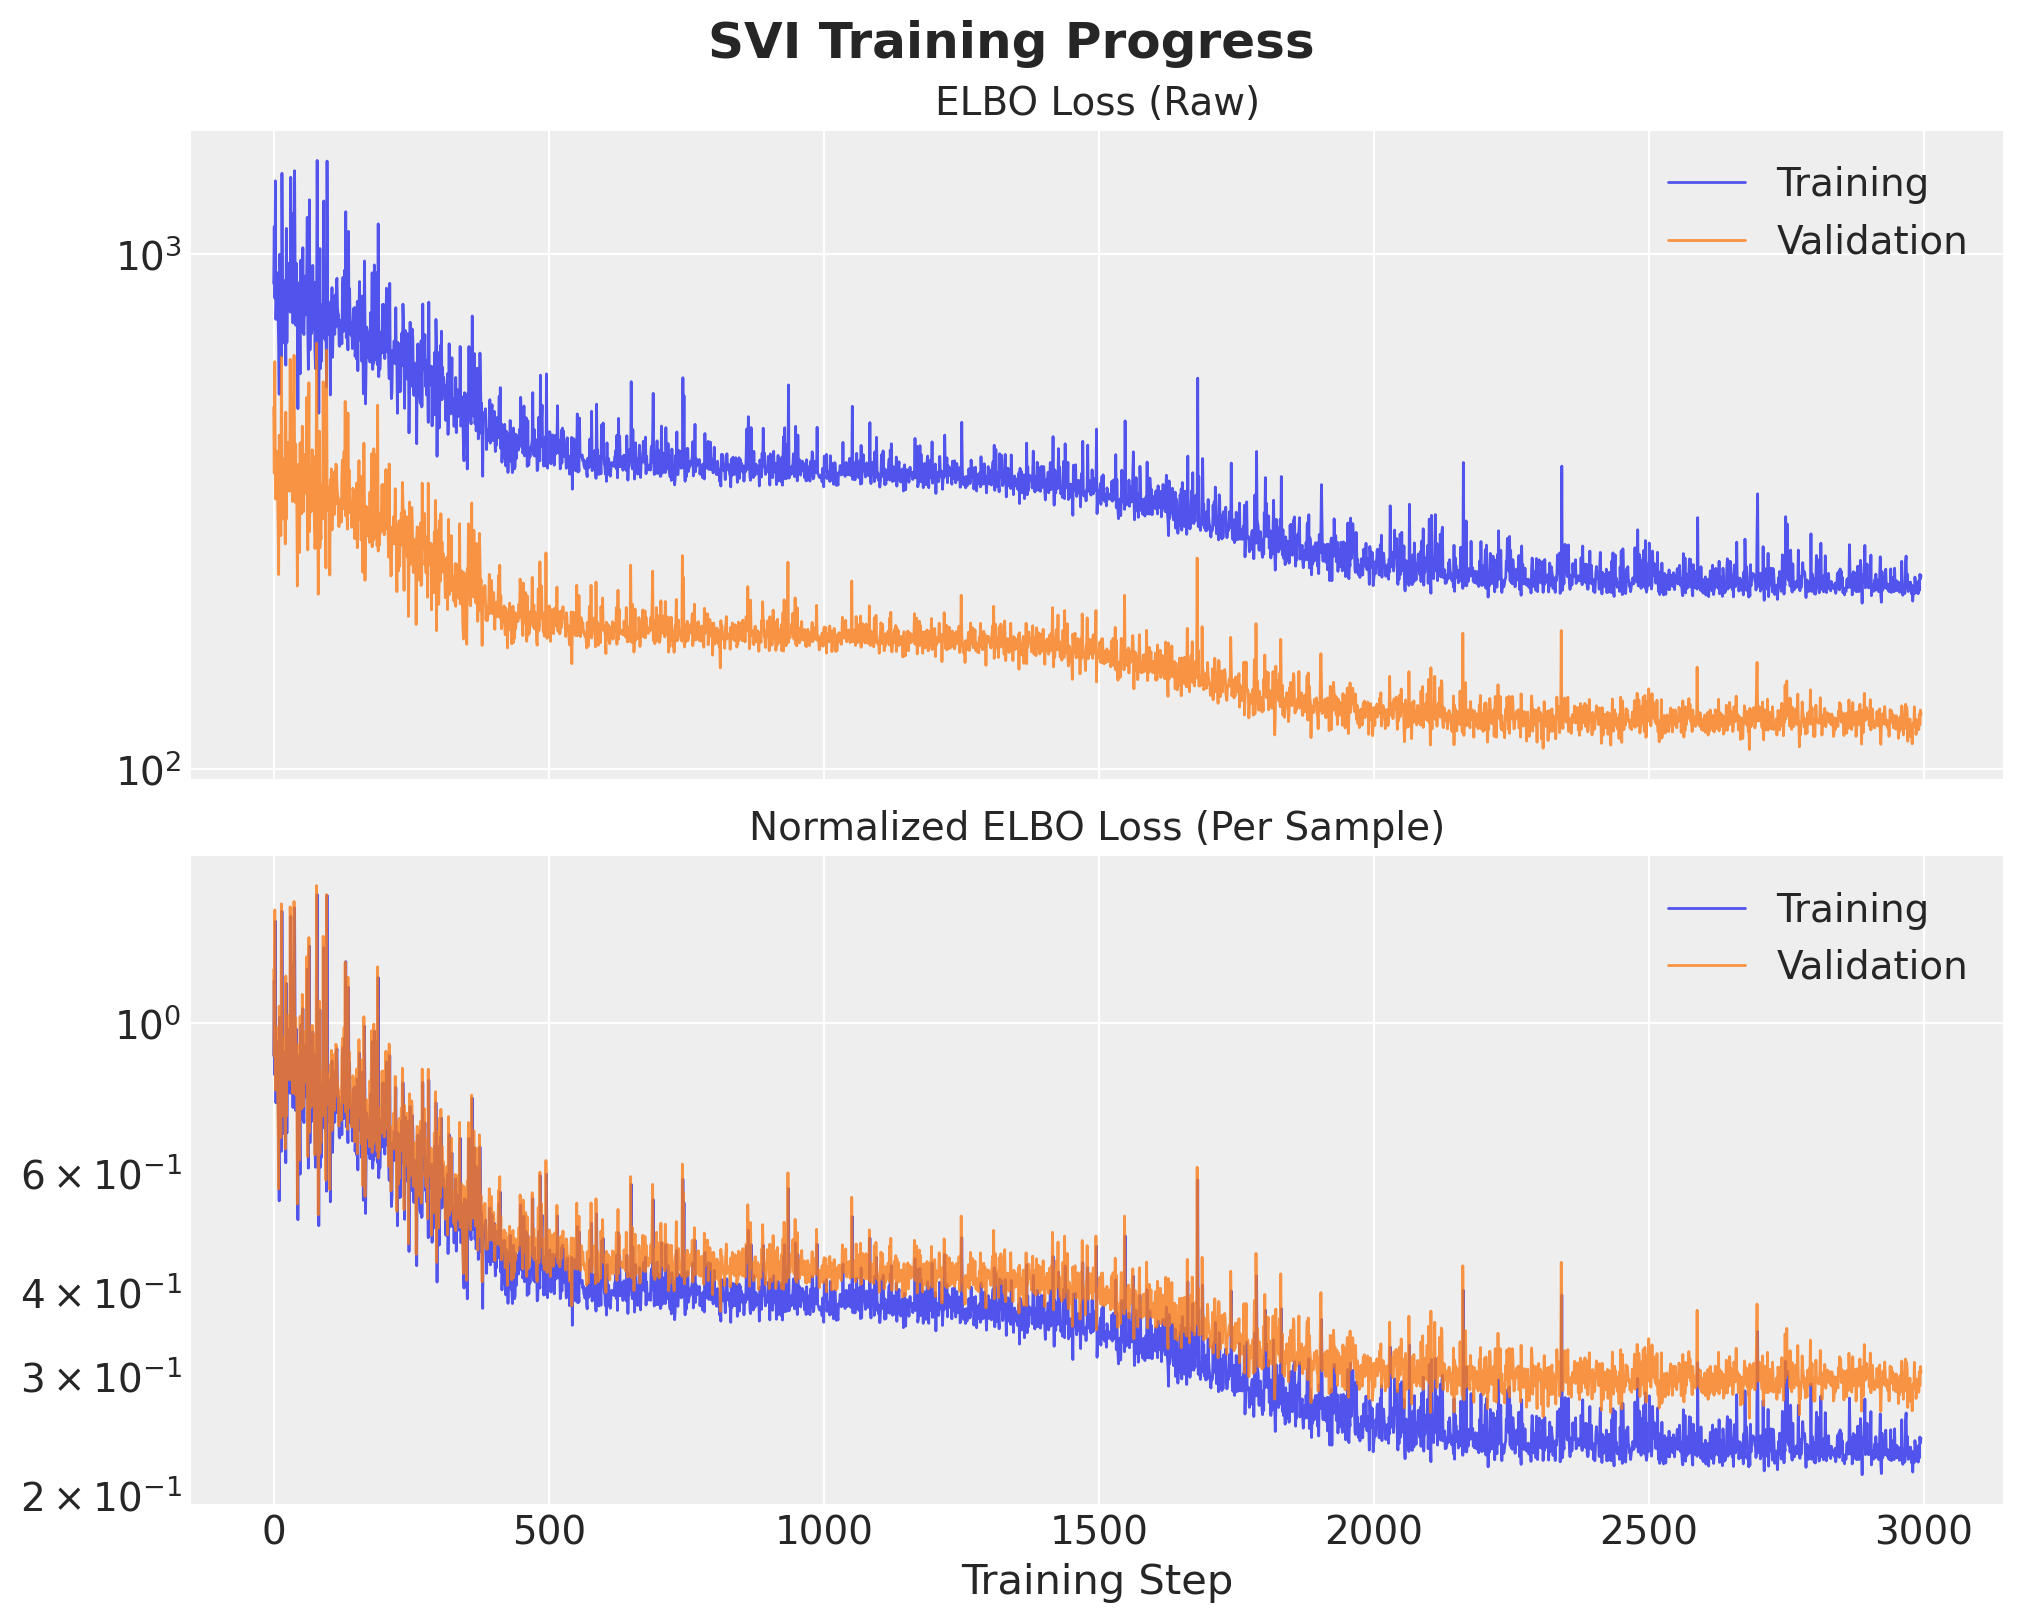

In [26]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, figsize=(10, 8), sharex=True, sharey=False, layout="constrained"
)

ax[0].plot(train_losses, c="C0", linewidth=1, alpha=0.8, label="Training")
ax[0].plot(val_losses, c="C1", linewidth=1, alpha=0.8, label="Validation")
ax[0].legend(loc="upper right")
ax[0].set(yscale="log")
ax[0].set_title("ELBO Loss (Raw)", fontsize=14)

ax[1].plot(norm_train_losses, c="C0", linewidth=1, alpha=0.8, label="Training")
ax[1].plot(norm_val_losses, c="C1", linewidth=1, alpha=0.8, label="Validation")
ax[1].legend(loc="upper right")
ax[1].set(yscale="log")
ax[1].set_xlabel("Training Step")
ax[1].set_title("Normalized ELBO Loss (Per Sample)", fontsize=14)

plt.suptitle("SVI Training Progress", fontsize=18, fontweight="bold");

We clearly see that the training loop stoped briefly after the training and validation losses separated.

## Posterior Predictive Analysis

Now that we've trained our variational approximation, let's use it to make predictions and analyze the results.

### Posterior Predictive Sampling

The **posterior predictive distribution** tells us what new data points would look like according to our trained model:

$$p(y_{\text{new}}|x_{\text{new}}, D) = \int p(y_{\text{new}}|x_{\text{new}}, \theta) p(\theta|D) \, d\theta$$

Since we can't compute the true posterior $p(\theta|D)$ exactly, we approximate it using our trained variational distribution $q_\phi(\theta)$:

$$p(y_{\text{new}}|x_{\text{new}}, D) \approx \int p(y_{\text{new}}|x_{\text{new}}, \theta) q_\phi(\theta) \, d\theta$$

In practice, we implement this via Monte Carlo sampling:
1. **Sample parameters** $\theta^{(s)} \sim q_\phi(\theta)$ from our trained variational approximation
2. **Forward pass** each parameter sample through the network to get $p(y_{\text{new}}|x_{\text{new}}, \theta^{(s)})$
3. **Sample predictions** from the resulting Bernoulli distributions

Let's do this for the training data:


In [27]:
# Extract the optimized variational parameters
params = svi_result.params

# Create posterior predictive sampler for training data
train_posterior_predictive = Predictive(
    model=model,  # Our BNN model
    guide=guide,  # Our trained variational guide
    params=params,  # Optimized variational parameters
    num_samples=2_000,  # Number of posterior samples to draw
    return_sites=["p", "y"],  # Return both probabilities and predictions
)

# Generate samples for training data
rng_key, rng_subkey = random.split(key=rng_key)
train_posterior_predictive_samples = train_posterior_predictive(rng_subkey, x_train)

# Convert to ArviZ InferenceData for analysis and visualization
train_idata = az.from_dict(
    posterior_predictive={
        # Add chain dimension for ArviZ compatibility
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in train_posterior_predictive_samples.items()
    },
    coords={"obs_idx": idx_train},  # Coordinate labels for observations
    dims={
        "p": ["obs_idx"],  # Probability predictions
        "y": ["obs_idx"],  # Binary predictions
    },
)

Similarly, we can generate samples for the test data:

In [28]:
# Generate posterior predictive samples for test data
test_posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=params,
    num_samples=2_000,
    return_sites=["p", "y"],
)

# Generate samples for test data
rng_key, rng_subkey = random.split(key=rng_key)
test_posterior_predictive_samples = test_posterior_predictive(rng_subkey, x_test)

# Convert to ArviZ InferenceData
test_idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in test_posterior_predictive_samples.items()
    },
    coords={"obs_idx": idx_test},
    dims={
        "p": ["obs_idx"],
        "y": ["obs_idx"],
    },
)

### Model Performance Evaluation

We'll evaluate our Bayesian Neural Network using the **Area Under the ROC Curve (AUC)** metric. The beauty of the Bayesian approach is that we get a **distribution** of AUC scores rather than a single point estimate.

#### Why AUC?

1. **Threshold-independent**: Evaluates performance across all classification thresholds
2. **Probability-aware**: Uses predicted probabilities, not just hard classifications
3. **Balanced metric**: Accounts for both sensitivity and specificity
4. **Uncertainty-friendly**: Can be computed for each posterior sample

#### Bayesian Model Evaluation

For each posterior sample $\theta^{(s)}$, we compute:

$$\text{AUC}^{(s)} = \text{AUC}(y_{\text{true}}, p^{(s)})$$

This gives us a **distribution** of performance metrics, allowing us to quantify uncertainty in model performance itself!

In [29]:
auc_train = xr.apply_ufunc(
    roc_auc_score,  # Function to apply
    y_train,  # True labels (same for all samples)
    train_idata["posterior_predictive"][
        "p"
    ],  # Predicted probabilities (varies by sample)
    input_core_dims=[["obs_idx"], ["obs_idx"]],  # Dimensions to apply function over
    output_core_dims=[[]],  # Output is scalar
    vectorize=True,  # Apply to each sample independently
)

# Compute AUC score for each posterior sample on test data
auc_test = xr.apply_ufunc(
    roc_auc_score,
    y_test,
    test_idata["posterior_predictive"]["p"],
    input_core_dims=[["obs_idx"], ["obs_idx"]],
    output_core_dims=[[]],
    vectorize=True,
)

print("AUC distributions computed:")
print(f"  Training AUC: {auc_train.mean():.3f} ± {auc_train.std():.3f}")
print(f"  Test AUC: {auc_test.mean():.3f} ± {auc_test.std():.3f}")

# Compute point estimates using posterior mean predictions
train_mean_auc = roc_auc_score(
    y_train, train_idata["posterior_predictive"]["p"].mean(dim=("chain", "draw"))
)

test_mean_auc = roc_auc_score(
    y_test, test_idata["posterior_predictive"]["p"].mean(dim=("chain", "draw"))
)

print("Point estimates (using posterior mean):")
print(f"  Training AUC: {train_mean_auc:.3f}")
print(f"  Test AUC: {test_mean_auc:.3f}")

AUC distributions computed:
  Training AUC: 0.984 ± 0.002
  Test AUC: 0.981 ± 0.003
Point estimates (using posterior mean):
  Training AUC: 0.986
  Test AUC: 0.983


Let's visualize the **distribution** of AUC scores. This shows us not just how well our model performs on average, but also how uncertain we are about that performance.

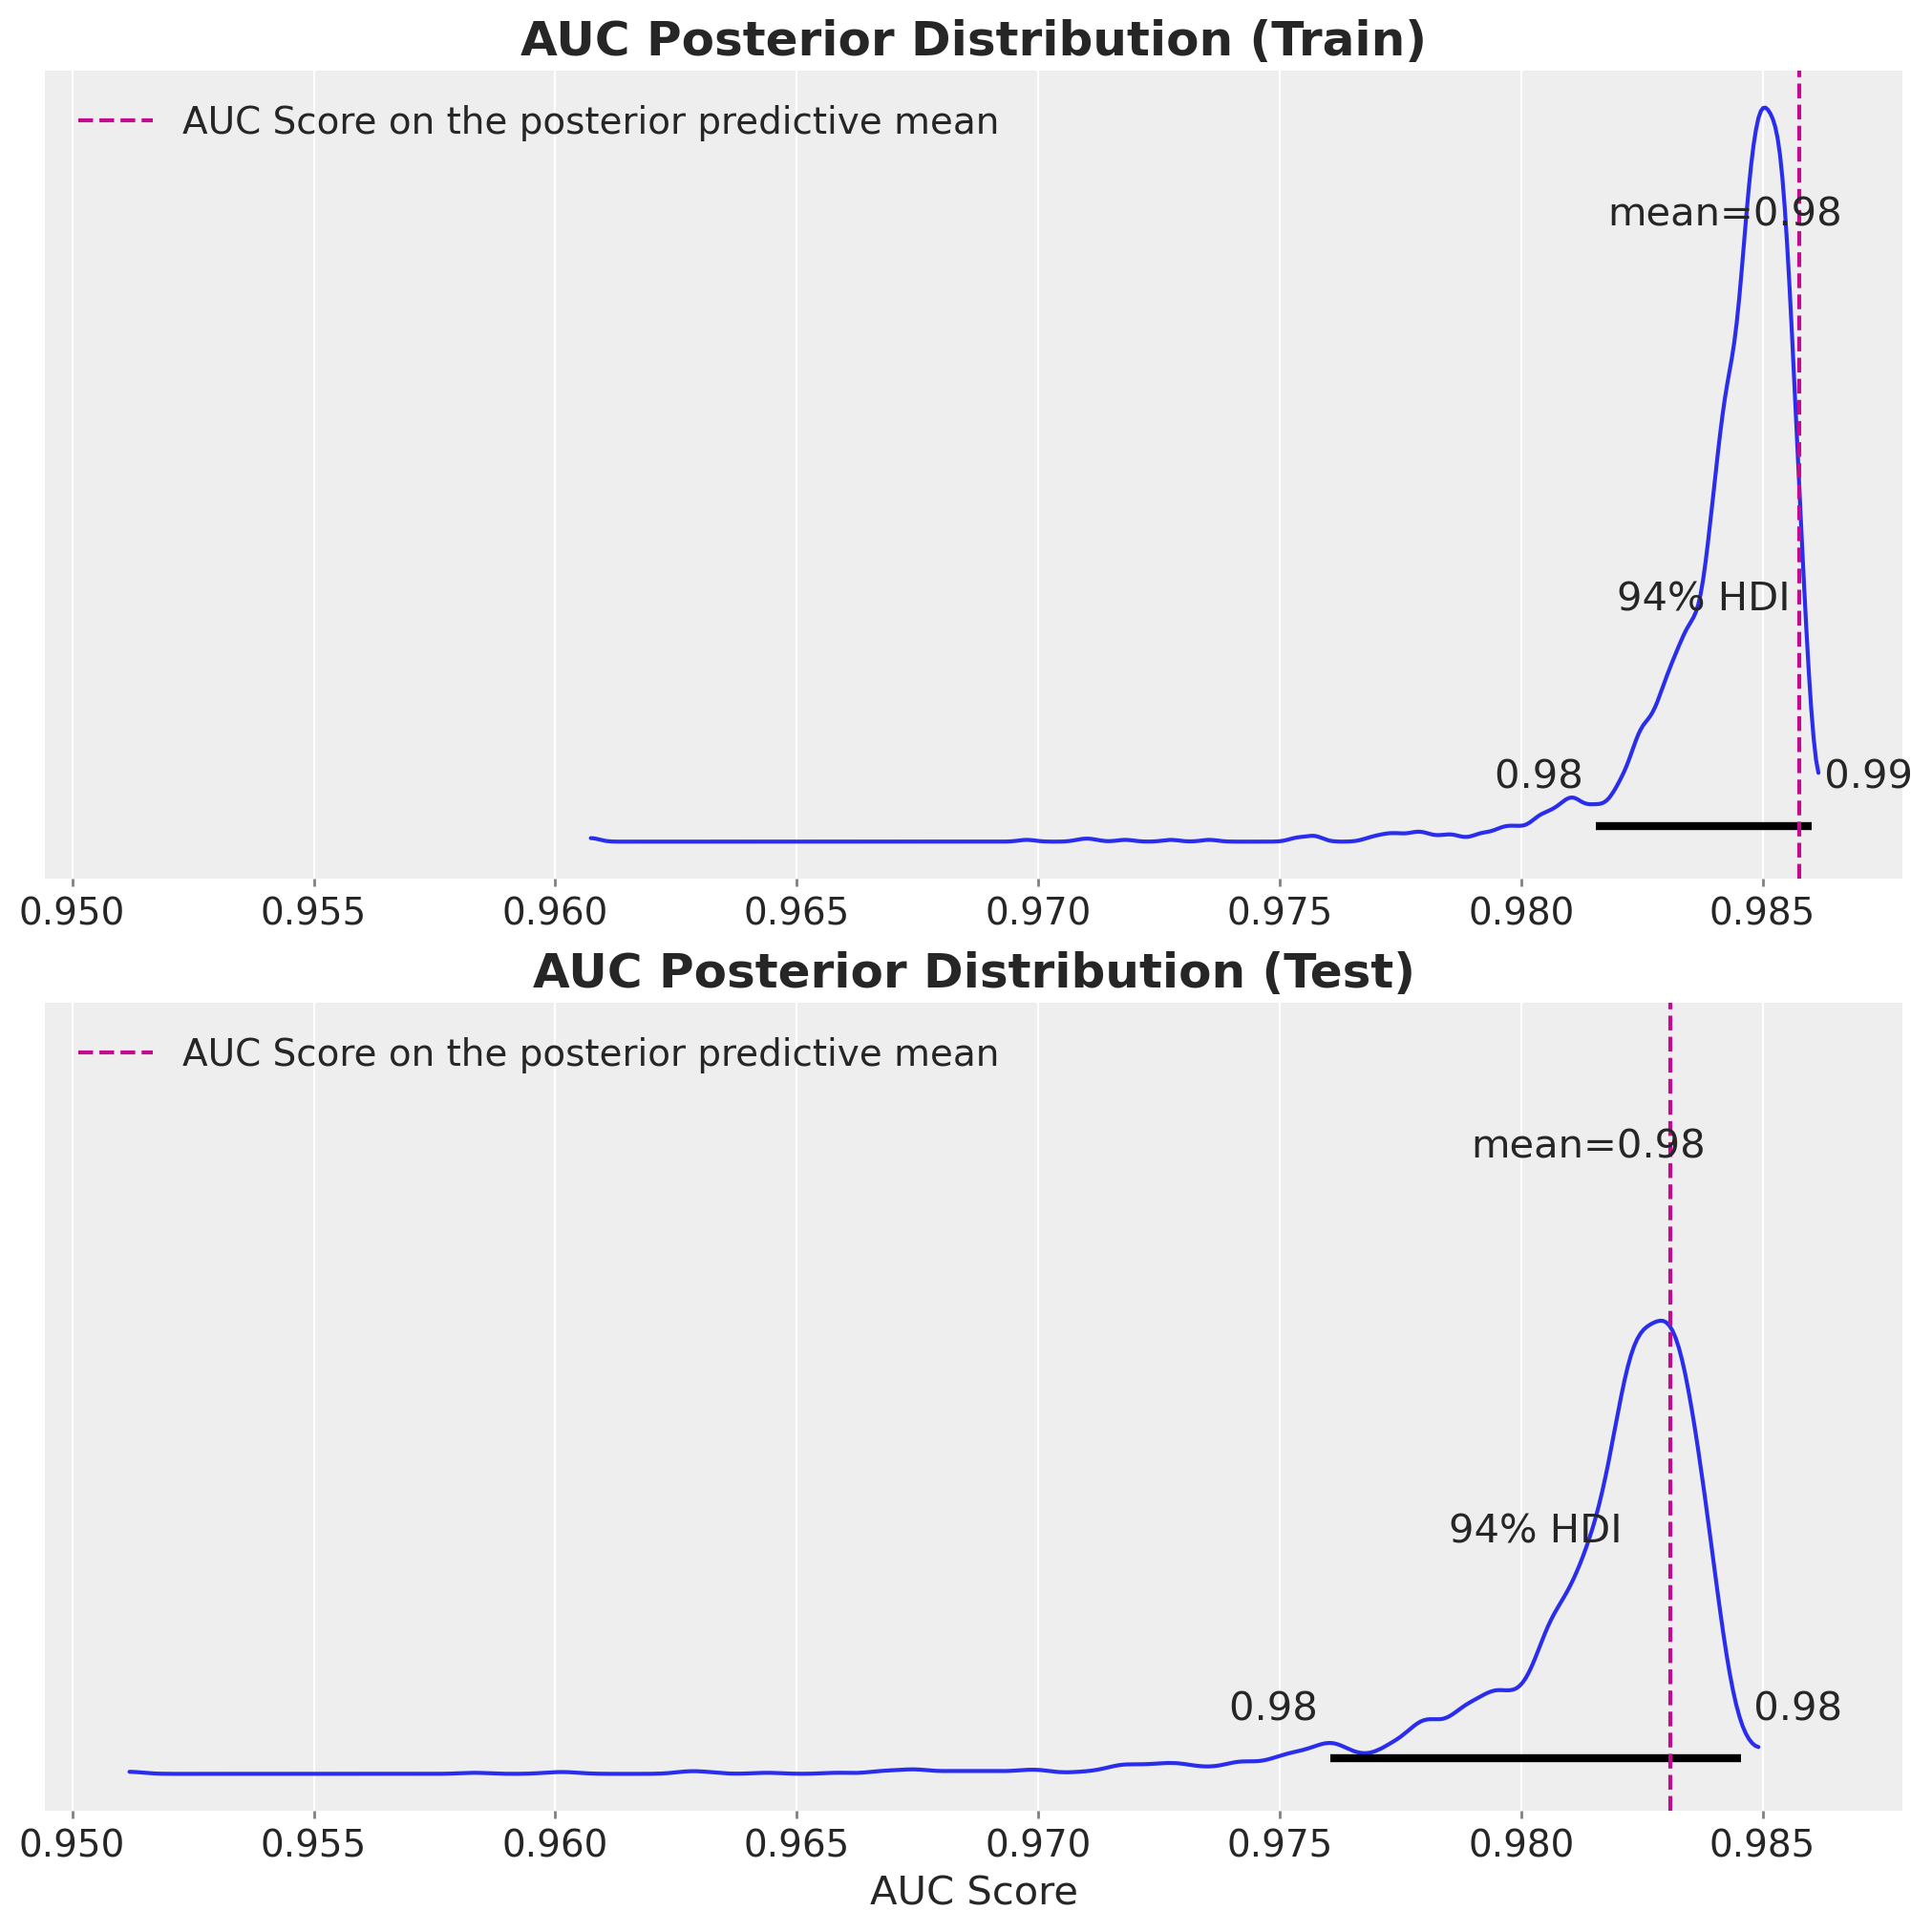

In [30]:
fig, ax = plt.subplots(
    nrows=2,
    ncols=1,
    figsize=(10, 10),
    sharex=True,
    sharey=True,
    layout="constrained",
)
az.plot_posterior(data=auc_train, ax=ax[0])
ax[0].axvline(
    roc_auc_score(
        y_train, train_idata["posterior_predictive"]["p"].mean(dim=("chain", "draw"))
    ),
    color="C3",
    linestyle="--",
    label="AUC Score on the posterior predictive mean",
)
ax[0].legend(loc="upper left")
ax[0].set_title("AUC Posterior Distribution (Train)", fontsize=18, fontweight="bold")

az.plot_posterior(data=auc_test, ax=ax[1])
ax[1].axvline(
    roc_auc_score(
        y_test, test_idata["posterior_predictive"]["p"].mean(dim=("chain", "draw"))
    ),
    color="C3",
    linestyle="--",
    label="AUC Score on the posterior predictive mean",
)
ax[1].legend(loc="upper left")
ax[1].set(xlabel="AUC Score")
ax[1].set_title("AUC Posterior Distribution (Test)", fontsize=18, fontweight="bold");

From these metrics, we see that the model is performing well on both the training and test sets.

### ROC Curve Analysis

The **Receiver Operating Characteristic (ROC)** curve shows the trade-off between true positive rate and false positive rate across all classification thresholds.

#### Bayesian ROC Analysis

Since we have multiple posterior samples, we can compute a **distribution** of ROC curves. This shows:

1. **Average performance**: The central tendency of ROC curves
2. **Uncertainty bands**: How much the performance varies across parameter samples
3. **Robustness**: Whether performance is consistent across the posterior

Each curve represents the ROC for one set of sampled network parameters.

In order to vectorize the computation of the ROC curve, we need a little helper function.

In [31]:
def _roc_curve(y_true, y_score, cut: int = 0):
    """
    Compute ROC curve with truncation for consistent array sizes.

    This helper function ensures all ROC curves have the same length
    for easier visualization and analysis.

    Parameters
    ----------
    y_true : array-like
        True binary labels
    y_score : array-like
        Predicted probabilities
    cut : int
        Number of points to cut from the end of the ROC curve
        This is just to aliviate the fact that the ROC curve is not always the same
        length even if we force it with the drop_intermediate=False parameter.

    Returns
    -------
    tuple
        Truncated false positive rates, true positive rates, and thresholds
    """
    fpr, tpr, thresholds = roc_curve(
        y_true=y_true,
        y_score=y_score,
        drop_intermediate=False,  # Keep all points for smoother curves
    )

    # Truncate to consistent length (avoids xarray size mismatch issues)
    n = y_true.shape[0] - cut
    return fpr[:n], tpr[:n], thresholds[:n]

Now, we can compute the ROC curves of the posterior predictive samples for both the training and test sets.

In [32]:
cut = 3

# Compute ROC curves for training data across all posterior samples
fpr_train, tpr_train, thresholds_train = xr.apply_ufunc(
    lambda x, y: _roc_curve(y_true=x, y_score=y, cut=cut),
    y_train,  # True labels
    train_idata["posterior_predictive"]["p"],  # Predicted probabilities
    input_core_dims=[["obs_idx"], ["obs_idx"]],  # Input dimensions
    output_core_dims=[["threshld"], ["threshld"], ["threshld"]],  # Output dimensions
    vectorize=True,  # Apply to each sample
)

# Compute ROC curves for test data across all posterior samples
fpr_test, tpr_test, thresholds_test = xr.apply_ufunc(
    lambda x, y: _roc_curve(y_true=x, y_score=y, cut=cut),
    y_test,
    test_idata["posterior_predictive"]["p"],
    input_core_dims=[["obs_idx"], ["obs_idx"]],
    output_core_dims=[["threshld"], ["threshld"], ["threshld"]],
    vectorize=True,
)

 Now let's visualize the **ensemble** of ROC curves. Each light-colored (small opacity `alpha=0.2`) line represents one posterior sample, while the overall pattern shows the model's consistency.

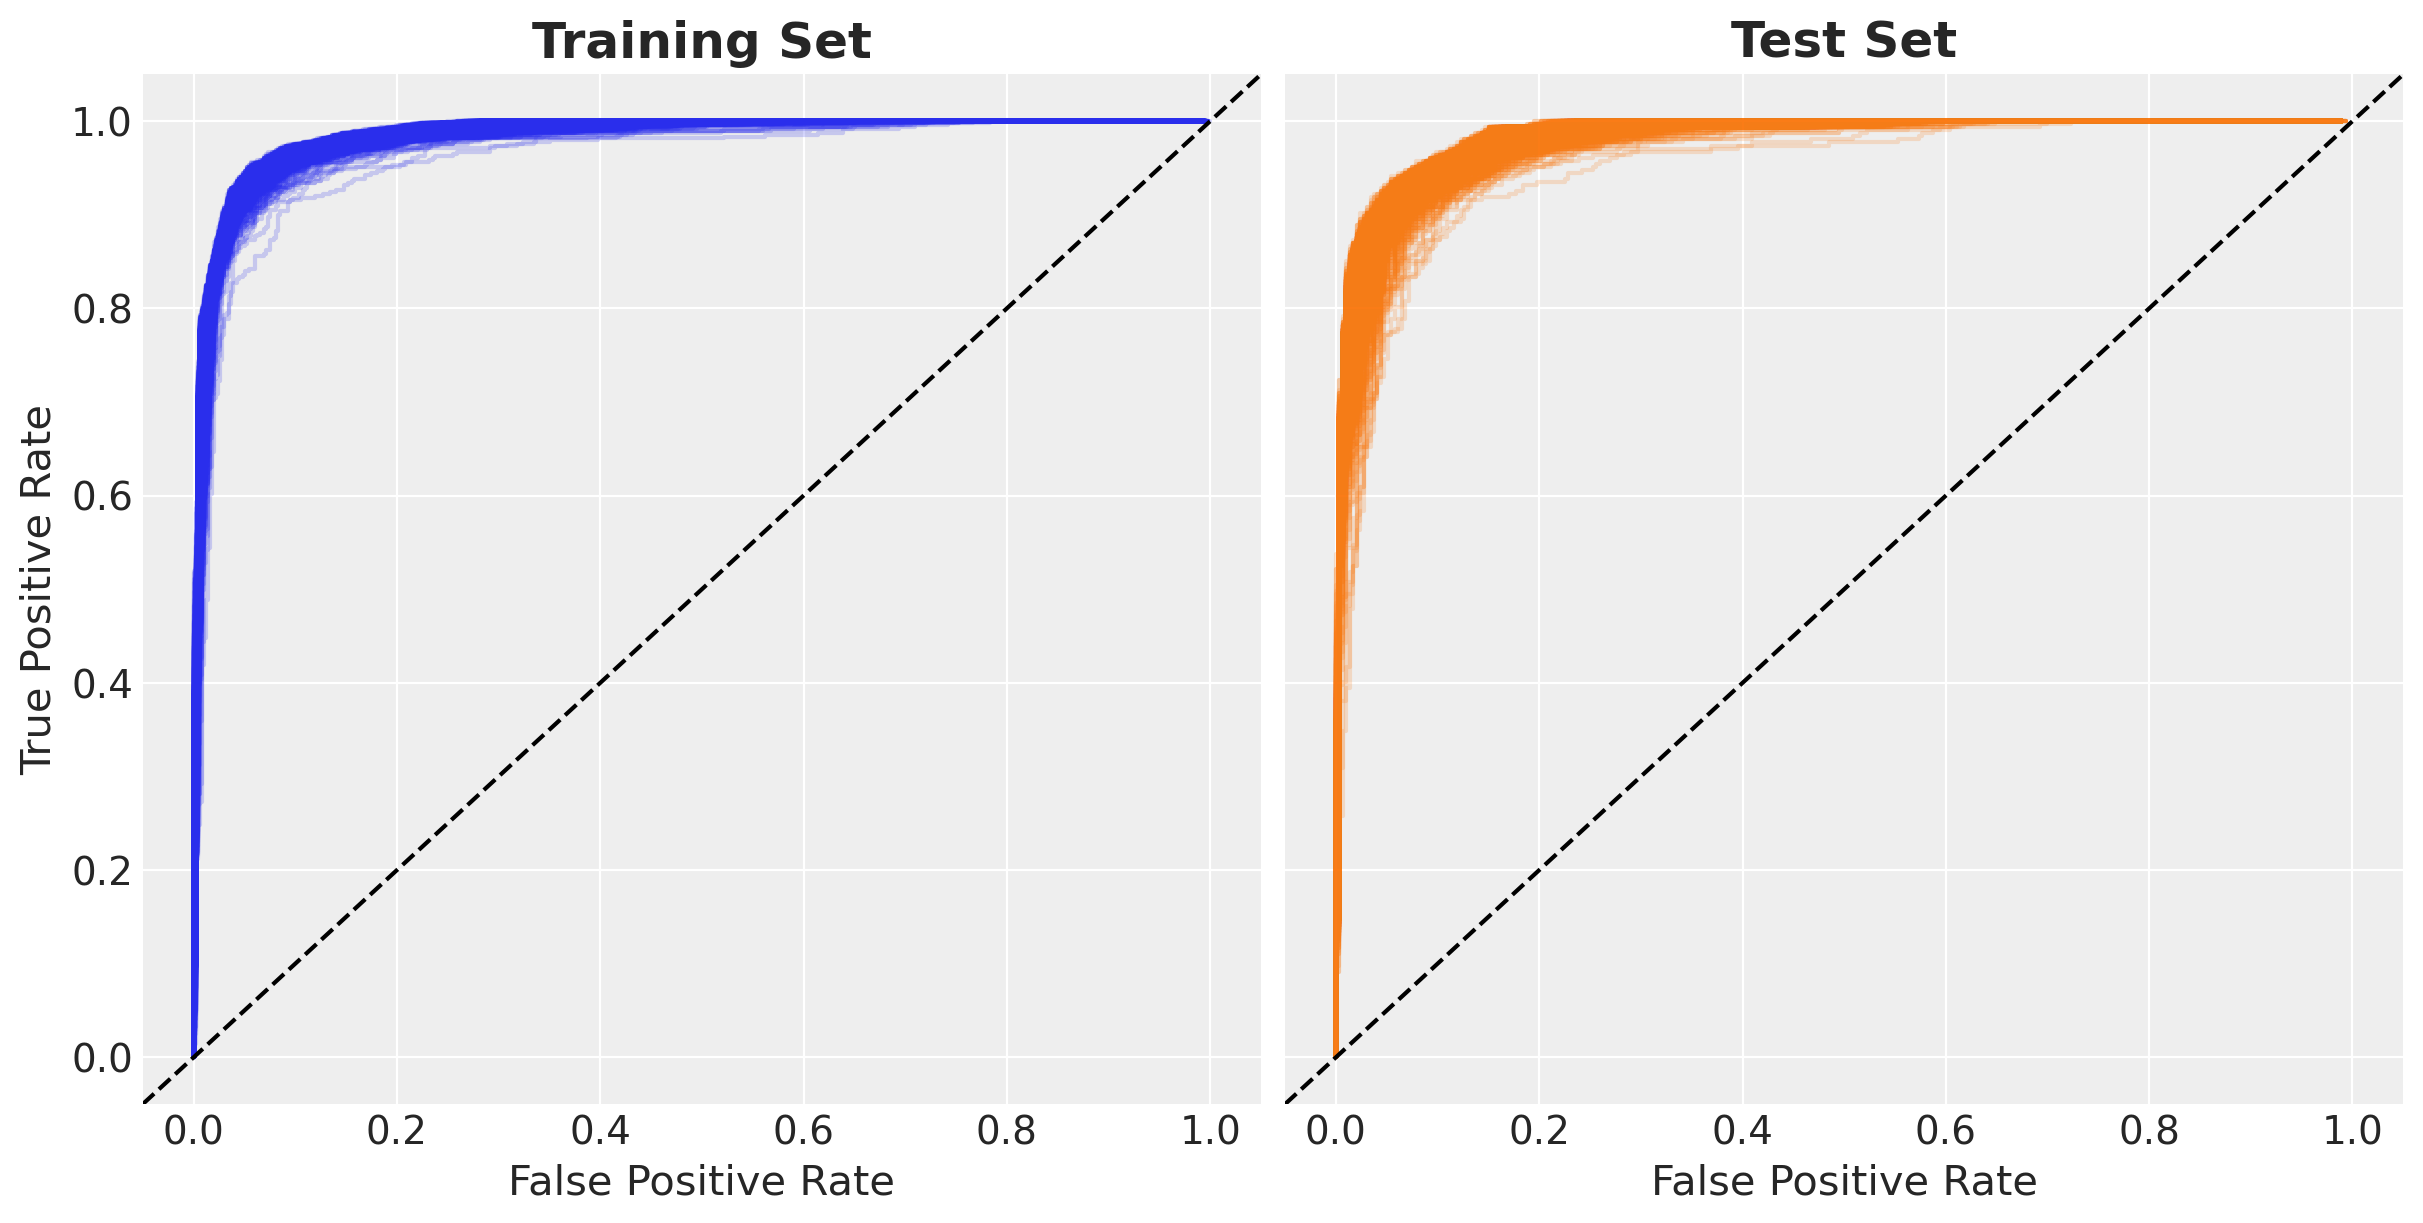

In [33]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 6),
    sharex=True,
    sharey=True,
    layout="constrained",
)

for i in range(2_000):
    ax[0].plot(
        fpr_train.sel(chain=0, draw=i),
        tpr_train.sel(chain=0, draw=i),
        c="C0",
        alpha=0.2,
    )
    ax[1].plot(
        fpr_test.sel(chain=0, draw=i),
        tpr_test.sel(chain=0, draw=i),
        c="C1",
        alpha=0.2,
    )


ax[0].axline(
    (0, 0),
    (1, 1),
    color="black",
    linestyle="--",
)

ax[0].set(xlabel="False Positive Rate", ylabel="True Positive Rate")
ax[0].set_title("Training Set", fontsize=18, fontweight="bold")

ax[1].axline(
    (0, 0),
    (1, 1),
    color="black",
    linestyle="--",
)

ax[1].set(xlabel="False Positive Rate")
ax[1].set_title("Test Set", fontsize=18, fontweight="bold");

### Prediction Visualization

Finally, let's visualize our model's predictions in the original feature space. This will show us:

1. **Decision boundary**: How the model separates the two classes
2. **Prediction confidence**: Areas where the model is more/less certain
3. **Uncertainty patterns**: Where Bayesian uncertainty is highest

To start by plotting the **posterior mean predictions** - the average probability across all posterior samples. The color intensity represents the predicted probability of belonging to class 1.

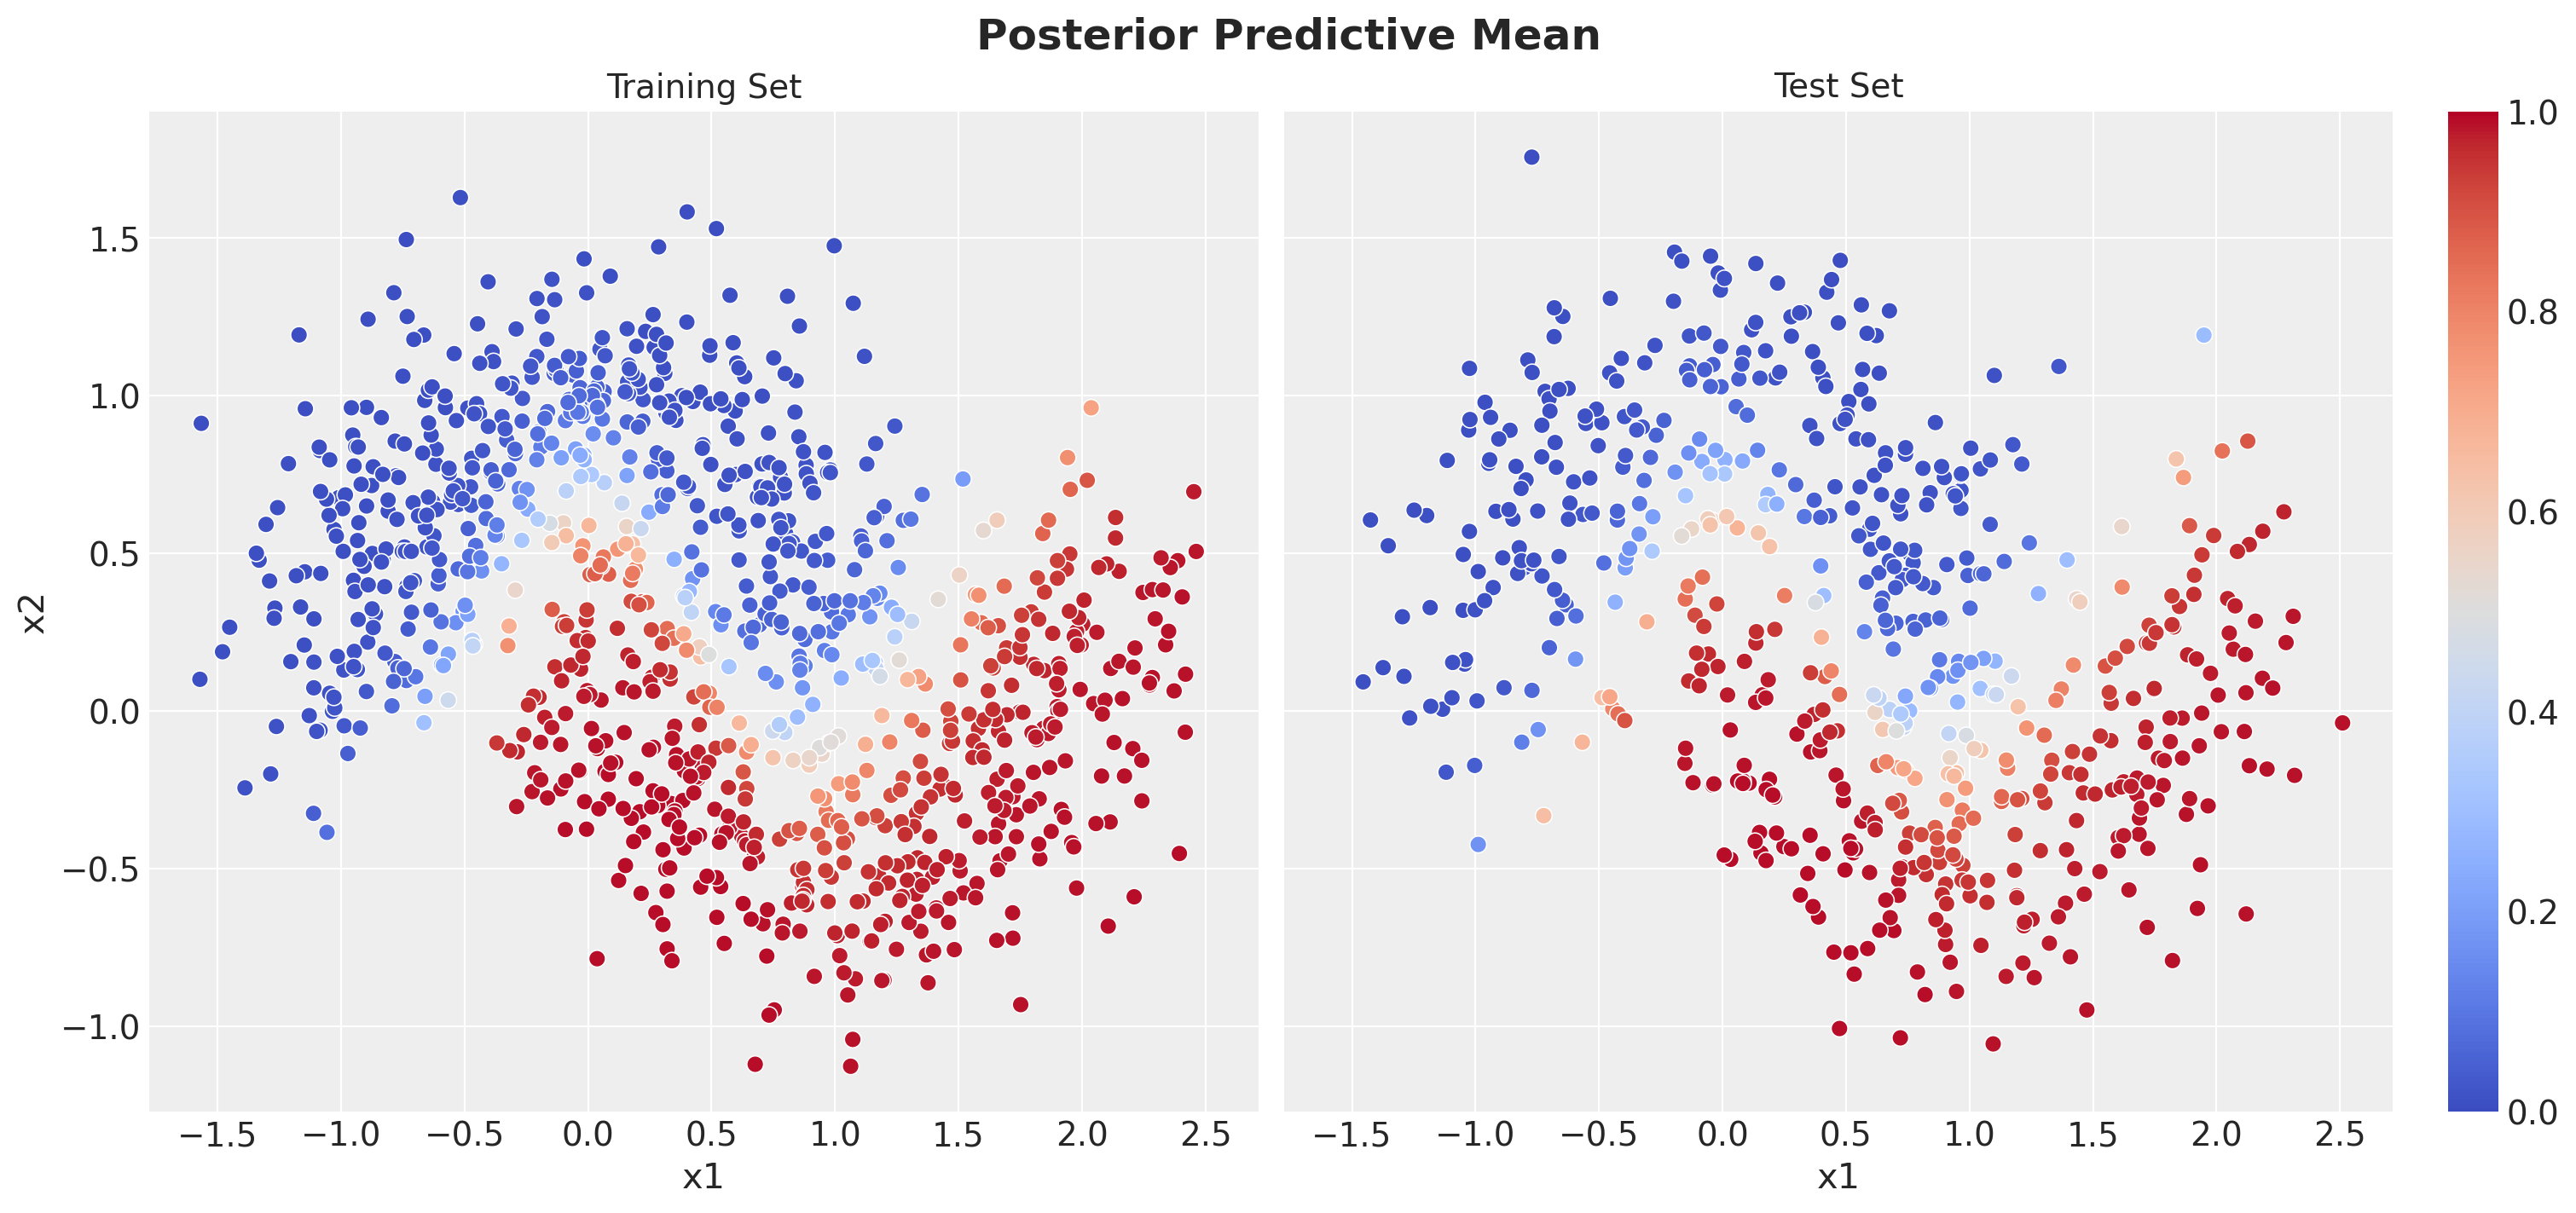

In [34]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

(
    train_idata["posterior_predictive"]["p"]
    .mean(dim=("chain", "draw"))
    .to_pandas()
    .to_frame()
    .assign(x1=x_train[:, 0], x2=x_train[:, 1])
    .pipe(
        (sns.scatterplot, "data"),
        x="x1",
        y="x2",
        hue="p",
        hue_norm=(0, 1),
        palette="coolwarm",
        s=50,
        ax=ax[0],
    )
)

ax[0].legend().remove()
ax[0].set_title("Training Set", fontsize=14)

(
    test_idata["posterior_predictive"]["p"]
    .mean(dim=("chain", "draw"))
    .to_pandas()
    .to_frame()
    .assign(x1=x_test[:, 0], x2=x_test[:, 1])
    .pipe(
        (sns.scatterplot, "data"),
        x="x1",
        y="x2",
        hue="p",
        hue_norm=(0, 1),
        palette="coolwarm",
        s=50,
        ax=ax[1],
    )
)

mappable = plt.cm.ScalarMappable(cmap="coolwarm", norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(mappable, ax=ax[1])

ax[1].legend().remove()
ax[1].set_title("Test Set", fontsize=14)

fig.suptitle("Posterior Predictive Mean", fontsize=18, fontweight="bold");

We see that the model is able to capture the non-linear decision boundary of the data.

Next, to understand the uncertainty of the model, we can plot the width of the HDI of the posterior distribution of the latent variable $p$. We did something similar in the prior predictive analysis above. The larger the HDI, the more uncertain the model is about its predictions.

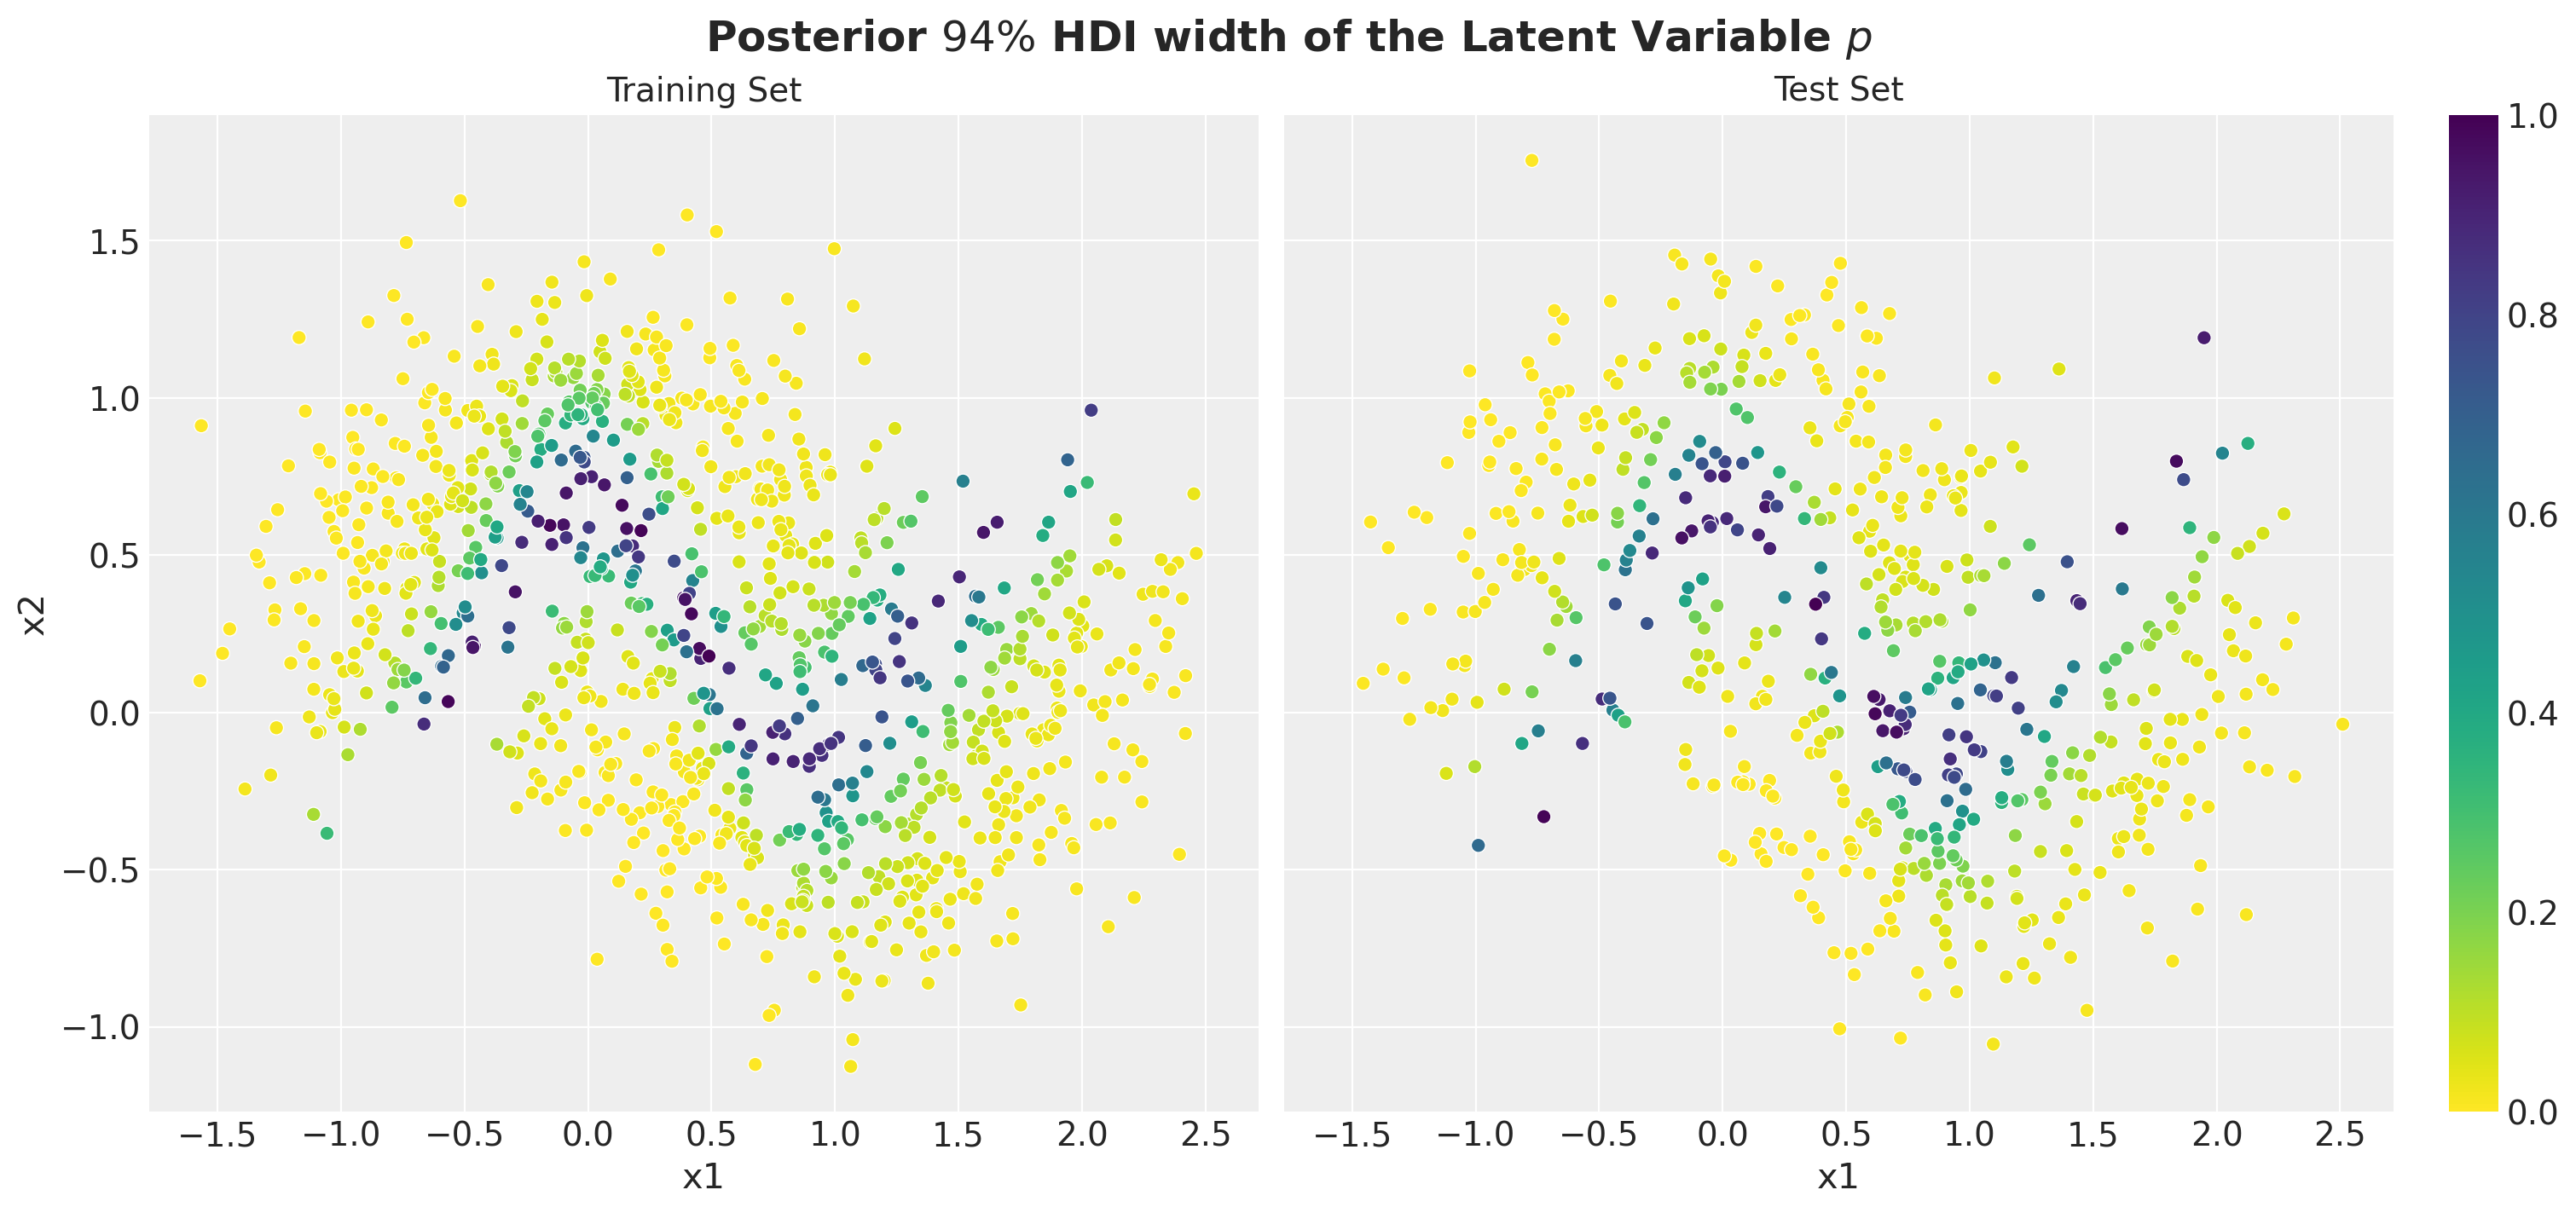

In [35]:
# HDI of the posterior predictive distribution
train_p_hdi = az.hdi(train_idata["posterior_predictive"]["p"], hdi_prob=0.94)
test_p_hdi = az.hdi(test_idata["posterior_predictive"]["p"], hdi_prob=0.94)
# Compute the width of the HDI
train_hdi_width = train_p_hdi.sel(hdi="higher") - train_p_hdi.sel(hdi="lower")
test_hdi_width = test_p_hdi.sel(hdi="higher") - test_p_hdi.sel(hdi="lower")

fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

(
    train_hdi_width.rename({"p": "hdi_width"})
    .to_pandas()
    .assign(x1=x_train[:, 0], x2=x_train[:, 1])
    .pipe(
        (sns.scatterplot, "data"),
        x="x1",
        y="x2",
        hue="hdi_width",
        palette="viridis_r",
        ax=ax[0],
    )
)

ax[0].legend().remove()
ax[0].set_title("Training Set", fontsize=14)

(
    test_hdi_width.rename({"p": "hdi_width"})
    .to_pandas()
    .assign(x1=x_test[:, 0], x2=x_test[:, 1])
    .pipe(
        (sns.scatterplot, "data"),
        x="x1",
        y="x2",
        hue="hdi_width",
        palette="viridis_r",
    )
)

mappable = plt.cm.ScalarMappable(cmap="viridis_r", norm=plt.Normalize(vmin=0, vmax=1))
cbar = plt.colorbar(mappable, ax=ax[1])

ax[1].legend().remove()
ax[1].set_title("Test Set", fontsize=14)
fig.suptitle(
    r"Posterior $94\%$ HDI width of the Latent Variable $p$",
    fontsize=18,
    fontweight="bold",
);

It is interesting (expected) to see that the model is the most uncertain close to the decision boundary.

Finally, we want to see how the model predicts outside the range of the training data. For this, we will create a grid of points and plot the posterior mean predictions and the HDI width.

In [36]:
# Grid of points to evaluate the model
n_grid = 100
x_grid_0 = jnp.linspace(-5, 5, n_grid)
# Create a grid of points to evaluate the model using the meshgrid function
# which does a cartesian product of the x_grid_0 array with itself.
x_grid = jnp.array(jnp.meshgrid(x_grid_0, x_grid_0)).T.reshape(-1, 2)
idx_grid = np.arange(x_grid.shape[0])

# Posterior predictive samples
grid_posterior_predictive = Predictive(
    model=model,
    guide=guide,
    params=params,
    num_samples=2_000,
    return_sites=["p", "y"],
)

rng_key, rng_subkey = random.split(key=rng_key)
grid_posterior_predictive_samples = grid_posterior_predictive(rng_subkey, x_grid)

# Convert to ArviZ InferenceData
grid_idata = az.from_dict(
    posterior_predictive={
        k: np.expand_dims(a=np.asarray(v), axis=0)
        for k, v in grid_posterior_predictive_samples.items()
    },
    coords={"obs_idx": idx_grid},
    dims={
        "p": ["obs_idx"],
        "y": ["obs_idx"],
    },
)
# Compute the HDI of the posterior predictive distribution
grid_p_hdi = az.hdi(grid_idata["posterior_predictive"]["p"], hdi_prob=0.94)
# Compute the width of the HDI
grid_hdi_width = (grid_p_hdi.sel(hdi="higher") - grid_p_hdi.sel(hdi="lower"))[
    "p"
].to_numpy()

Let's visualize the posterior predictive distribution of the model and the HDI width of the latent variable $p$ on this grid of points.

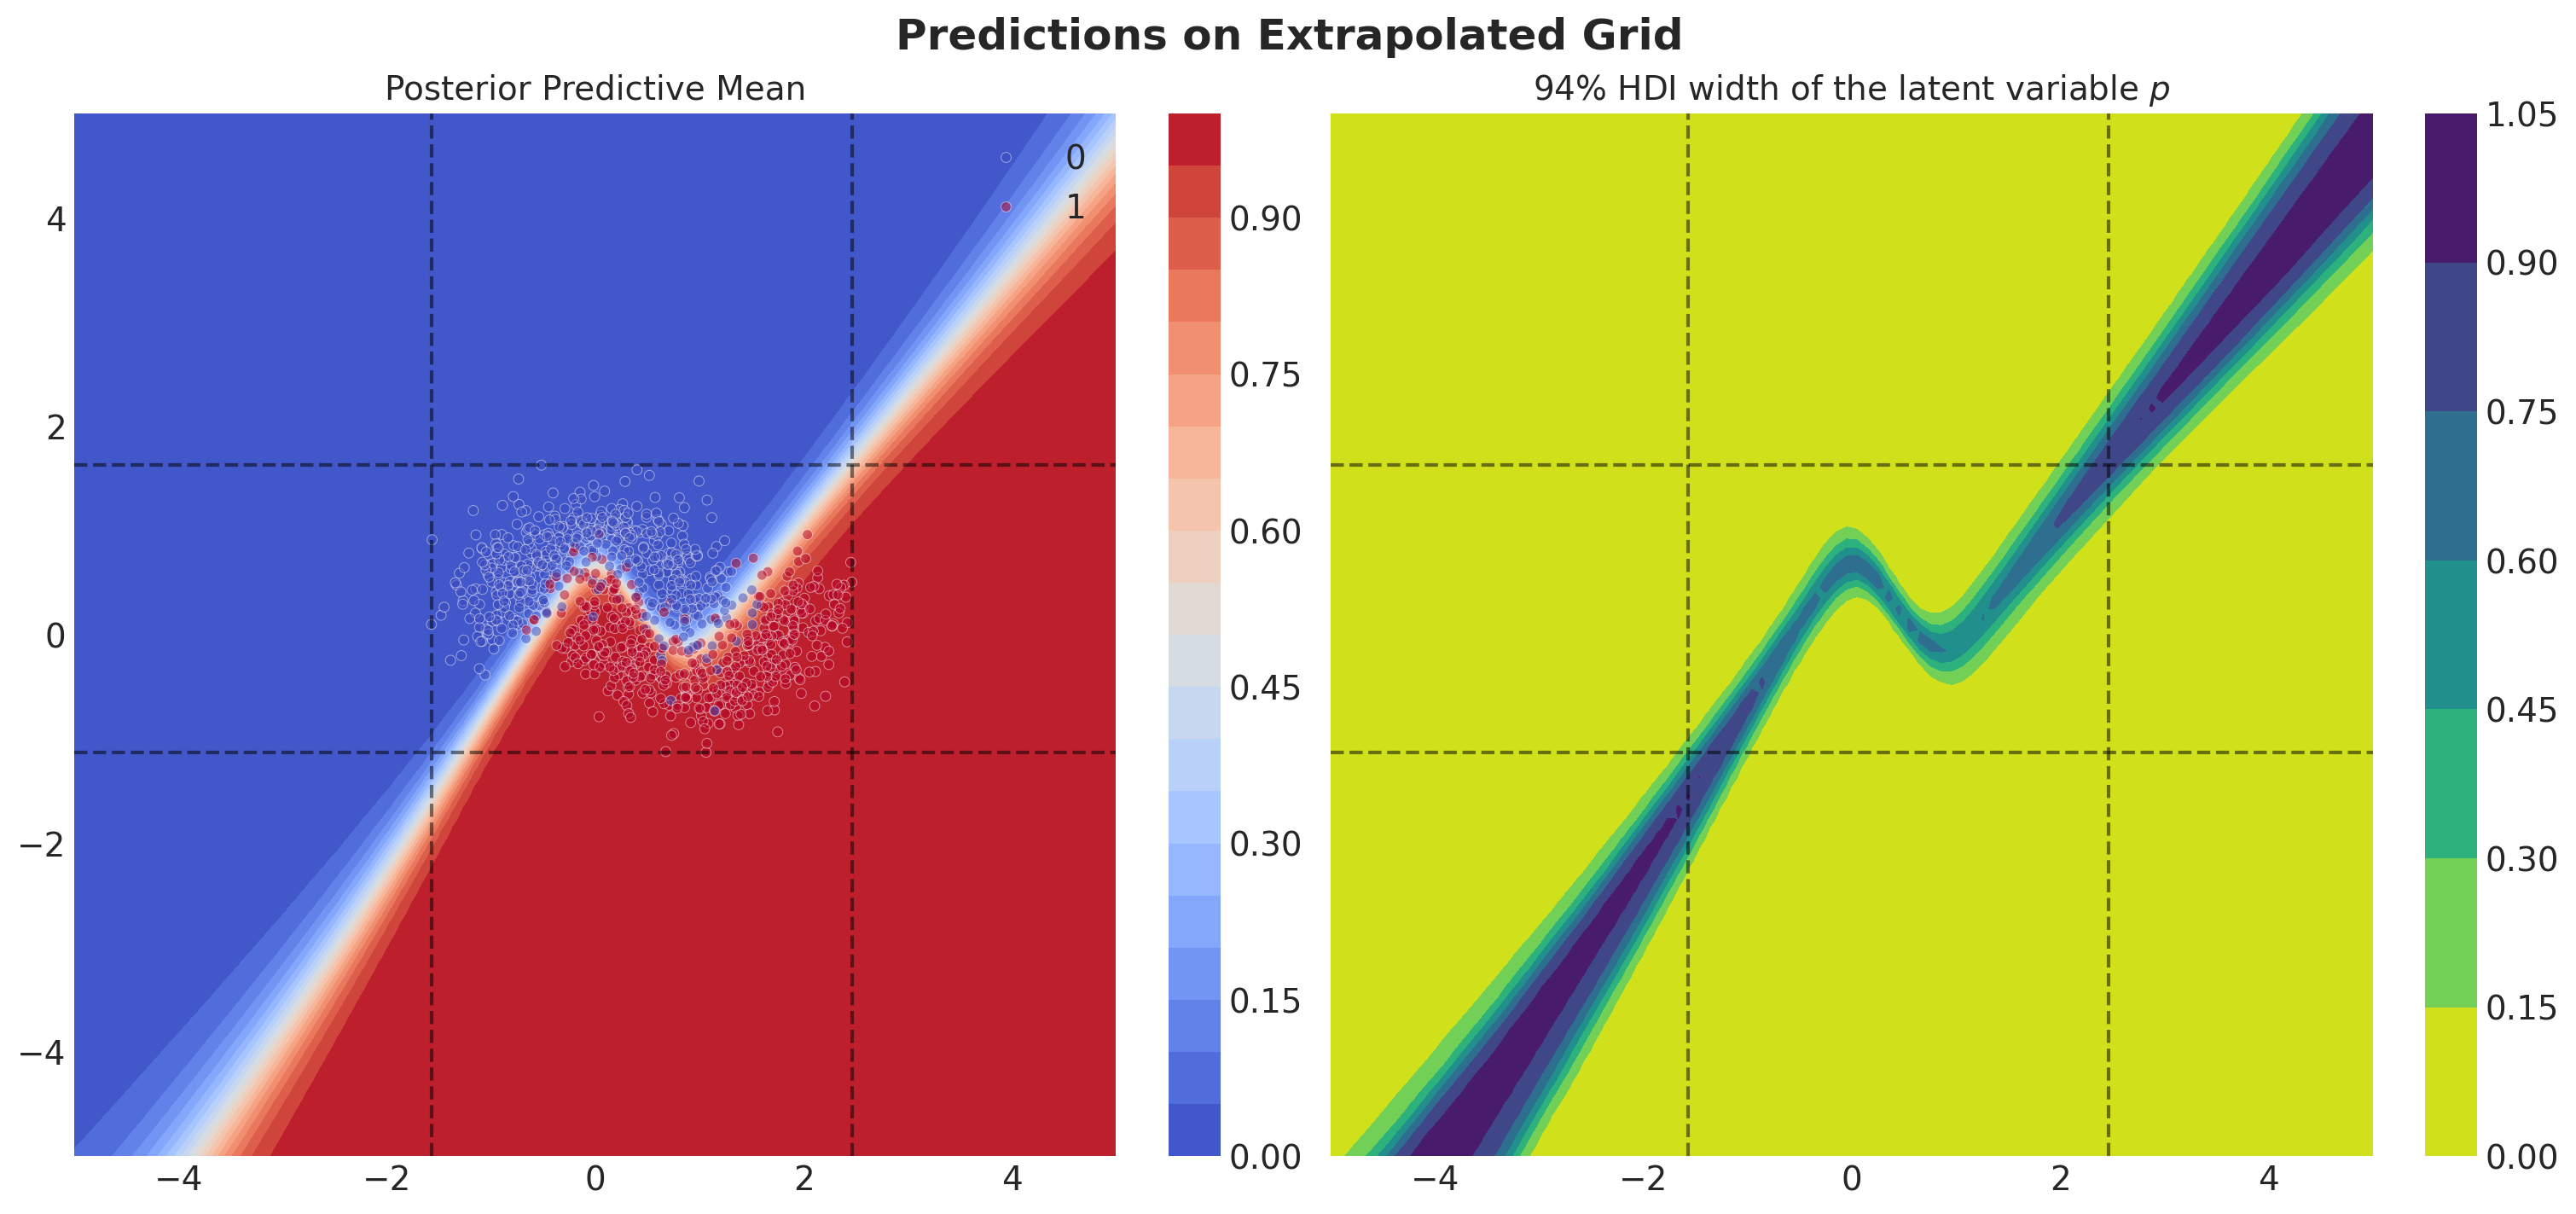

In [37]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(15, 7),
    sharex=True,
    sharey=True,
    layout="constrained",
)

p_mean = grid_idata["posterior_predictive"]["p"].mean(dim=("chain", "draw")).to_numpy()

cs0 = ax[0].contourf(
    x_grid_0,
    x_grid_0,
    p_mean.reshape(n_grid, n_grid).T,
    vmin=0,
    vmax=1,
    cmap="coolwarm",
    levels=20,
)


cb0 = fig.colorbar(cs0, ax=ax[0])

sns.scatterplot(
    x=x_train[:, 0],
    y=x_train[:, 1],
    s=18,
    hue=y_train,
    palette=colors,
    alpha=0.5,
    ax=ax[0],
)

ax[0].axvline(x=x_train[:, 0].min(), color="black", linestyle="--", alpha=0.5)
ax[0].axvline(x=x_train[:, 0].max(), color="black", linestyle="--", alpha=0.5)
ax[0].axhline(y=x_train[:, 1].min(), color="black", linestyle="--", alpha=0.5)
ax[0].axhline(y=x_train[:, 1].max(), color="black", linestyle="--", alpha=0.5)

ax[0].set_title("Posterior Predictive Mean", fontsize=14)


cs1 = ax[1].contourf(
    x_grid_0,
    x_grid_0,
    grid_hdi_width.reshape(n_grid, n_grid).T,
    cmap="viridis_r",
)

cb1 = fig.colorbar(cs1, ax=ax[1])

ax[1].axvline(x=x_train[:, 0].min(), color="black", linestyle="--", alpha=0.5)
ax[1].axvline(x=x_train[:, 0].max(), color="black", linestyle="--", alpha=0.5)
ax[1].axhline(y=x_train[:, 1].min(), color="black", linestyle="--", alpha=0.5)
ax[1].axhline(y=x_train[:, 1].max(), color="black", linestyle="--", alpha=0.5)

ax[1].set_title(r"$94\%$ HDI width of the latent variable $p$", fontsize=14)

fig.suptitle("Predictions on Extrapolated Grid", fontsize=18, fontweight="bold");

Observe that the model becomes less certain of the decision boundary as we move away from the training data. This is a featrue we would expect from a Bayesian model. 

## Summary and Key Takeaways

### What We've Accomplished

1. **Implemented a Bayesian Neural Network** using NumPyro's SVI framework
2. **Learned complex non-linear decision boundaries** for the two moons dataset
3. **Quantified uncertainty** in both parameters and predictions
4. **Evaluated performance** using probabilistic metrics (AUC distributions)
5. **Visualized results** including ROC curves and prediction landscapes

### Key Advantages of SVI

- ✅ **Scalability**: Can handle large datasets through mini-batching
- ✅ **Speed**: Faster than MCMC for most applications
- ✅ **Uncertainty Quantification**: Provides meaningful uncertainty estimates
- ✅ **Deterministic**: Reproducible results for deployment
- ✅ **Flexible**: Works with complex models (neural networks, etc.)

### When to Use SVI vs MCMC

**Use SVI when:**
- You have large datasets
- You need fast inference for production systems
- You can accept approximate (vs exact) posterior inference

**Use MCMC when:**
- You have small-medium datasets
- You need precise posterior samples
- You have time for longer computation

### Resources for Learning More

- [NumPyro Documentation](https://num.pyro.ai/)
- [Pyro SVI Tutorial](https://pyro.ai/examples/svi_part_i.html)
- [Blei et al. (2017): Variational Inference Review](https://arxiv.org/abs/1601.00670)
- [Hoffman et al. (2013): Stochastic Variational Inference](https://arxiv.org/abs/1206.7051)